<a href="https://colab.research.google.com/github/joanats/classificador-gatos-cachorros/blob/main/Case_Cromai_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **🌱Desafio Cromai: Classificador de Imagens - Cachorros vs Gatos**

## **Entendimento do problema**

No futuro, gatinhos sabotadores dominaram o mundo e só há uma esperança: criar cães mecânicos capazes de identificá-los. Para isso, **precisamos de um modelo de classificação de imagens** que diferencie entre gatos malvados e cachorros do bem.

> Este notebook documenta o desenvolvimento e análise de modelos para o desafio proposto pela Cromai, utilizando técnicas de machine learning.



## **Objetivos do Desafio**

O objetivo deste desafio é desenvolver um **modelo de Inteligência Artificial** capaz de classificar imagens entre gatos e cachorros, com foco em auxiliar uma narrativa futurista na qual cães mecânicos precisam ser treinados para identificar gatinhos malvados e cachorrinhos fofinhos.

Além disso, o desafio também pede:

> - Crie arquivos CSV com os valores de perda, acurácia de validação dos modelos
classificadores que você criou.
> - Realize pelo menos dois novos experimentos alterando alguma configuração do script ou
do dataset para tentar obter uma performance melhor do que conseguimos.
> - Coloque nos CSVs alguma informação sobre o que foi alterado para conseguir esse
resultado e por que realizou essa alteração.



### **Justificativa da Implementação**

Utilizei o arquivo `train.py` disponibilizado como um ponto de partida e referência para entender a estrutura e o fluxo geral do treinamento dos modelos.  
No entanto, para facilitar a experimentação e controle dos parâmetros, decidi implementar o modelo em um notebook Jupyter (Colab) (`.ipynb`), o que me permitiu trabalhar de forma mais interativa, testar diferentes classificadores rapidamente e documentar melhor o processo.

Essa abordagem garantiu maior flexibilidade e clareza durante o desenvolvimento, ao mesmo tempo que respeitou a base fornecida pelo código original.

## **Configurações Iniciais**

 Baixando o arquivo do desafio - O arquivo está hospedado no Google Drive e é acessado via o ID compartilhado

In [ ]:
!gdown 1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB


Downloading...
From (original): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB
From (redirected): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB&confirm=t&uuid=f8567ad8-3baf-4b13-8050-991655313282
To: /content/case_cats_and_dogs.zip
100% 573M/573M [00:05<00:00, 99.3MB/s]


Descompacta o arquivo 'case_cats_and_dogs.zip' que contém as imagens e o script train.py


In [ ]:
!unzip case_cats_and_dogs

Archive:  case_cats_and_dogs.zip
replace case_cats_and_dogs/cats_and_dogs/class_cat/class1_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Excluindo o arquivo compactado

In [ ]:
!rm -rf case_cats_and_dogs.zip

Importando as bibliotecas necessárias

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
from pycaret.classification import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import base64
import random
import os

In [ ]:
data_dir = "./case_cats_and_dogs/cats_and_dogs"

Definição dos caminhos das pastas de gatos e cachorros, utilizando a biblioteca `os` [11].

In [ ]:
class_cat_dir = os.path.join(data_dir, "class_cat")
class_dog_dir = os.path.join(data_dir, "class_dog")

Neste projeto, utilizamos **Transfer Learning**, uma técnica que permite reaproveitar o conhecimento aprendido por uma rede neural treinada em um grande conjunto de dados (neste caso, o ImageNet), aplicando-o a um novo problema com um dataset menor.

A arquitetura escolhida foi a **VGG16**, fornecida pelo Keras. A linha abaixo carrega esse modelo com os seguintes parâmetros:

- `weights='imagenet'`: carrega os pesos treinados com o grande banco de dados ImageNet (com milhões de imagens em 1000 classes).
- `include_top=False`: remove as camadas densas finais responsáveis pela classificação original (1000 classes do ImageNet), permitindo que a gente adicione **nossas próprias camadas personalizadas** para o novo problema: classificar gatos e cachorros.

Este modelo passa então a atuar como um **extrator de características visuais** (features) das imagens, e as novas camadas finais que serão adicionadas posteriormente serão treinadas apenas com nosso conjunto de imagens.



Decidi utilizar a VGG16 pois é uma arquitetura **profundamente estudada e validada**, conhecida por sua **simplicidade** e **eficácia em tarefas de classificação de imagens**, me entregando como resultado a redução de treinamento e melhora da performace com poucos dados.

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

Agora criei a função `extract_features()` para processar uma imagem e extrair suas **características visuais (features)** usando a VGG16 pré-treinada.

Esse processo é fundamental no Transfer Learning, pois ao invés de treinar a rede do zero, aproveitamos a VGG16 como um **extrator de padrões visuais**, convertendo cada imagem em um vetor numérico (feature vector) que será usado por um classificador (como o PyCaret).
 [1] [7].


In [ ]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

Limitei o número de imagens por classe para 1000 para balancear entre a diversidade dos dados e o tempo disponível para treino. Embora o dataset original contenha 25.000 imagens, usar todo o conjunto demandaria mais recursos computacionais e tempo.  
Essa quantidade permite **validar o modelo de forma eficiente**, podendo ser aumentada em etapas futuras para melhorar o desempenho.


In [ ]:
MAX_IMAGES_PER_CLASS = 1000
X = []
y = []


Nesta etapa, percorremos a pasta de imagens da classe “gato” e extraímos as **features numéricas** de cada uma usando a função `extract_features()` baseada na VGG16 [1].

Primeiro, listei apenas os arquivos válidos de imagem (.jpg, .jpeg, .png) e limitei a quantidade conforme o valor definido em `MAX_IMAGES_PER_CLASS`. Em seguida, cada imagem é processada individualmente, e seu vetor de características é armazenado na lista `X`, com o respectivo rótulo `0` (para a classe "gato") armazenado em `y`.

**Essa transformação permite que as imagens, que são dados visuais, sejam representadas numericamente e usadas por modelos de machine learning tradicionais.**


In [ ]:
print("Processando imagens de gatos...")
cat_images = [img for img in os.listdir(class_cat_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
cat_images = cat_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(cat_images):
    img_path = os.path.join(class_cat_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(0)

Processando imagens de gatos...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


  0%|          | 1/1000 [00:01<22:34,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


  0%|          | 2/1000 [00:02<15:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  0%|          | 3/1000 [00:02<13:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  0%|          | 4/1000 [00:03<12:28,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


  0%|          | 5/1000 [00:04<14:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


  1%|          | 6/1000 [00:05<15:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


  1%|          | 7/1000 [00:06<17:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  1%|          | 8/1000 [00:07<15:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  1%|          | 9/1000 [00:08<14:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  1%|          | 10/1000 [00:08<12:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  1%|          | 11/1000 [00:09<12:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|          | 12/1000 [00:10<12:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


  1%|▏         | 13/1000 [00:10<11:49,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  1%|▏         | 14/1000 [00:11<11:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  2%|▏         | 15/1000 [00:12<11:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  2%|▏         | 16/1000 [00:12<11:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 17/1000 [00:13<11:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 18/1000 [00:14<10:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 19/1000 [00:14<10:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 20/1000 [00:15<10:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  2%|▏         | 21/1000 [00:16<10:38,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


  2%|▏         | 22/1000 [00:16<10:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


  2%|▏         | 23/1000 [00:18<14:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


  2%|▏         | 24/1000 [00:19<14:36,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


  2%|▎         | 25/1000 [00:19<14:03,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  3%|▎         | 26/1000 [00:20<13:17,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


  3%|▎         | 27/1000 [00:21<12:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  3%|▎         | 28/1000 [00:21<12:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  3%|▎         | 29/1000 [00:22<11:24,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  3%|▎         | 30/1000 [00:23<11:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  3%|▎         | 31/1000 [00:23<11:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  3%|▎         | 32/1000 [00:24<11:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  3%|▎         | 33/1000 [00:25<10:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 34/1000 [00:25<10:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  4%|▎         | 35/1000 [00:26<10:29,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▎         | 36/1000 [00:27<10:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  4%|▎         | 37/1000 [00:27<10:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▍         | 38/1000 [00:28<10:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▍         | 39/1000 [00:28<10:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


  4%|▍         | 40/1000 [00:29<10:36,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


  4%|▍         | 41/1000 [00:30<12:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  4%|▍         | 42/1000 [00:32<15:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


  4%|▍         | 43/1000 [00:32<14:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▍         | 44/1000 [00:33<13:21,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  4%|▍         | 45/1000 [00:34<12:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  5%|▍         | 46/1000 [00:34<11:46,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  5%|▍         | 47/1000 [00:35<11:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  5%|▍         | 48/1000 [00:36<10:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  5%|▍         | 49/1000 [00:36<10:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  5%|▌         | 50/1000 [00:37<10:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  5%|▌         | 51/1000 [00:37<10:28,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▌         | 52/1000 [00:38<10:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  5%|▌         | 53/1000 [00:39<10:15,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  5%|▌         | 54/1000 [00:39<10:24,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  6%|▌         | 55/1000 [00:40<10:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


  6%|▌         | 56/1000 [00:41<10:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  6%|▌         | 57/1000 [00:41<10:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  6%|▌         | 58/1000 [00:42<09:56,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


  6%|▌         | 59/1000 [00:43<11:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


  6%|▌         | 60/1000 [00:44<14:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 61/1000 [00:46<16:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 62/1000 [00:47<18:10,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▋         | 63/1000 [00:48<19:05,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  6%|▋         | 64/1000 [00:49<16:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  6%|▋         | 65/1000 [00:50<14:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  7%|▋         | 66/1000 [00:50<13:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  7%|▋         | 67/1000 [00:51<12:26,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  7%|▋         | 68/1000 [00:52<11:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  7%|▋         | 69/1000 [00:52<11:32,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  7%|▋         | 70/1000 [00:53<10:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  7%|▋         | 71/1000 [00:54<10:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  7%|▋         | 72/1000 [00:54<10:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 73/1000 [00:55<10:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  7%|▋         | 74/1000 [00:56<10:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


  8%|▊         | 75/1000 [00:57<13:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


  8%|▊         | 76/1000 [00:58<13:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


  8%|▊         | 77/1000 [00:59<15:57,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  8%|▊         | 78/1000 [01:00<13:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  8%|▊         | 79/1000 [01:01<12:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  8%|▊         | 80/1000 [01:01<12:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


  8%|▊         | 81/1000 [01:02<11:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 82/1000 [01:03<10:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 83/1000 [01:03<10:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  8%|▊         | 84/1000 [01:04<10:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  8%|▊         | 85/1000 [01:05<09:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  9%|▊         | 86/1000 [01:05<10:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▊         | 87/1000 [01:06<09:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  9%|▉         | 88/1000 [01:06<09:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▉         | 89/1000 [01:07<09:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▉         | 90/1000 [01:08<09:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  9%|▉         | 91/1000 [01:08<09:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  9%|▉         | 92/1000 [01:09<09:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  9%|▉         | 93/1000 [01:10<12:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


  9%|▉         | 94/1000 [01:12<15:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 10%|▉         | 95/1000 [01:12<13:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 10%|▉         | 96/1000 [01:13<12:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 10%|▉         | 97/1000 [01:14<11:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 10%|▉         | 98/1000 [01:14<11:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 10%|▉         | 99/1000 [01:15<10:41,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 10%|█         | 100/1000 [01:16<10:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 10%|█         | 101/1000 [01:16<10:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 10%|█         | 102/1000 [01:17<09:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 10%|█         | 103/1000 [01:18<09:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 10%|█         | 104/1000 [01:18<10:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|█         | 105/1000 [01:19<09:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█         | 106/1000 [01:20<09:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 107/1000 [01:20<10:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 11%|█         | 108/1000 [01:21<10:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 109/1000 [01:22<09:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 11%|█         | 110/1000 [01:23<12:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 11%|█         | 111/1000 [01:24<14:51,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 11%|█         | 112/1000 [01:25<13:33,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█▏        | 113/1000 [01:26<12:31,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 11%|█▏        | 114/1000 [01:26<11:28,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 12%|█▏        | 115/1000 [01:27<10:38,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 12%|█▏        | 116/1000 [01:27<10:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 12%|█▏        | 117/1000 [01:28<10:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 12%|█▏        | 118/1000 [01:29<10:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 12%|█▏        | 119/1000 [01:29<10:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 12%|█▏        | 120/1000 [01:30<09:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 12%|█▏        | 121/1000 [01:31<09:50,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 12%|█▏        | 122/1000 [01:31<09:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 12%|█▏        | 123/1000 [01:32<09:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 12%|█▏        | 124/1000 [01:33<09:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 12%|█▎        | 125/1000 [01:33<09:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 13%|█▎        | 126/1000 [01:34<09:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 13%|█▎        | 127/1000 [01:35<12:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 13%|█▎        | 128/1000 [01:37<14:31,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 13%|█▎        | 129/1000 [01:37<13:15,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 130/1000 [01:38<12:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 13%|█▎        | 131/1000 [01:39<11:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 132/1000 [01:39<11:02,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 13%|█▎        | 133/1000 [01:40<10:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 13%|█▎        | 134/1000 [01:41<10:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 14%|█▎        | 135/1000 [01:42<10:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▎        | 136/1000 [01:42<10:10,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 14%|█▎        | 137/1000 [01:43<09:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▍        | 138/1000 [01:44<09:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 14%|█▍        | 139/1000 [01:44<09:30,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 14%|█▍        | 140/1000 [01:45<09:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 141/1000 [01:46<09:38,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 14%|█▍        | 142/1000 [01:46<09:22,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 143/1000 [01:47<09:29,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 14%|█▍        | 144/1000 [01:48<12:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 14%|█▍        | 145/1000 [01:50<14:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 15%|█▍        | 146/1000 [01:50<12:43,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 15%|█▍        | 147/1000 [01:51<11:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 15%|█▍        | 148/1000 [01:51<10:54,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 15%|█▍        | 149/1000 [01:52<10:33,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 15%|█▌        | 150/1000 [01:53<10:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 15%|█▌        | 151/1000 [01:53<09:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 15%|█▌        | 152/1000 [01:54<09:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 15%|█▌        | 153/1000 [01:55<09:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 15%|█▌        | 154/1000 [01:55<09:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 155/1000 [01:56<09:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 16%|█▌        | 156/1000 [01:57<09:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▌        | 157/1000 [01:57<09:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 16%|█▌        | 158/1000 [01:58<09:04,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 16%|█▌        | 159/1000 [01:59<08:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 16%|█▌        | 160/1000 [01:59<09:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 16%|█▌        | 161/1000 [02:01<11:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 16%|█▌        | 162/1000 [02:02<14:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 16%|█▋        | 163/1000 [02:03<12:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 16%|█▋        | 164/1000 [02:03<11:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 16%|█▋        | 165/1000 [02:04<11:10,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 17%|█▋        | 166/1000 [02:05<10:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 17%|█▋        | 167/1000 [02:05<09:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 17%|█▋        | 168/1000 [02:06<09:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 17%|█▋        | 169/1000 [02:07<09:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 17%|█▋        | 170/1000 [02:07<09:15,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 17%|█▋        | 171/1000 [02:09<11:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 17%|█▋        | 172/1000 [02:10<13:59,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 17%|█▋        | 173/1000 [02:11<12:37,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 17%|█▋        | 174/1000 [02:11<11:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 175/1000 [02:12<10:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 18%|█▊        | 176/1000 [02:13<11:32,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 18%|█▊        | 177/1000 [02:14<13:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 18%|█▊        | 178/1000 [02:16<15:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 18%|█▊        | 179/1000 [02:16<13:03,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 18%|█▊        | 180/1000 [02:17<11:57,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 18%|█▊        | 181/1000 [02:18<11:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 18%|█▊        | 182/1000 [02:18<10:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 18%|█▊        | 183/1000 [02:19<10:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 18%|█▊        | 184/1000 [02:20<09:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 18%|█▊        | 185/1000 [02:20<09:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 19%|█▊        | 186/1000 [02:21<09:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 19%|█▊        | 187/1000 [02:22<09:31,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 19%|█▉        | 188/1000 [02:22<09:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 19%|█▉        | 189/1000 [02:25<16:55,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 19%|█▉        | 190/1000 [02:28<22:42,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 191/1000 [02:30<26:47,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 19%|█▉        | 192/1000 [02:32<24:14,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 19%|█▉        | 193/1000 [02:32<19:42,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 19%|█▉        | 194/1000 [02:33<16:27,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 20%|█▉        | 195/1000 [02:34<13:54,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|█▉        | 196/1000 [02:34<12:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 20%|█▉        | 197/1000 [02:35<11:15,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|█▉        | 198/1000 [02:36<10:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 20%|█▉        | 199/1000 [02:36<10:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 20%|██        | 200/1000 [02:37<09:29,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 20%|██        | 201/1000 [02:38<09:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|██        | 202/1000 [02:38<09:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|██        | 203/1000 [02:39<09:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 20%|██        | 204/1000 [02:40<09:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 20%|██        | 205/1000 [02:40<09:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 21%|██        | 206/1000 [02:42<11:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 21%|██        | 207/1000 [02:43<13:37,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 21%|██        | 208/1000 [02:44<12:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 21%|██        | 209/1000 [02:44<10:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 21%|██        | 210/1000 [02:45<10:20,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 21%|██        | 211/1000 [02:46<09:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 21%|██        | 212/1000 [02:46<09:23,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 21%|██▏       | 213/1000 [02:47<09:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 21%|██▏       | 214/1000 [02:48<08:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 22%|██▏       | 215/1000 [02:48<08:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 22%|██▏       | 216/1000 [02:49<08:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 22%|██▏       | 217/1000 [02:50<08:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 22%|██▏       | 218/1000 [02:50<08:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 22%|██▏       | 219/1000 [02:51<08:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 22%|██▏       | 220/1000 [02:52<08:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 22%|██▏       | 221/1000 [02:52<08:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 22%|██▏       | 222/1000 [02:53<08:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


 22%|██▏       | 223/1000 [02:54<11:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 22%|██▏       | 224/1000 [02:56<13:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 22%|██▎       | 225/1000 [02:56<11:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 23%|██▎       | 226/1000 [02:57<10:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 23%|██▎       | 227/1000 [02:57<09:46,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 23%|██▎       | 228/1000 [02:58<09:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 229/1000 [02:59<09:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 23%|██▎       | 230/1000 [03:00<09:10,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 23%|██▎       | 231/1000 [03:00<09:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 23%|██▎       | 232/1000 [03:01<09:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 233/1000 [03:02<08:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 23%|██▎       | 234/1000 [03:02<08:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 24%|██▎       | 235/1000 [03:03<08:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 24%|██▎       | 236/1000 [03:04<08:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 24%|██▎       | 237/1000 [03:04<08:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 24%|██▍       | 238/1000 [03:05<08:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 24%|██▍       | 239/1000 [03:06<08:38,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


 24%|██▍       | 240/1000 [03:07<11:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 24%|██▍       | 241/1000 [03:08<11:44,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 24%|██▍       | 242/1000 [03:09<13:22,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▍       | 243/1000 [03:10<11:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 24%|██▍       | 244/1000 [03:11<10:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 24%|██▍       | 245/1000 [03:11<10:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 25%|██▍       | 246/1000 [03:12<09:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 25%|██▍       | 247/1000 [03:13<09:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 25%|██▍       | 248/1000 [03:13<09:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 25%|██▍       | 249/1000 [03:14<08:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 25%|██▌       | 250/1000 [03:15<08:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 25%|██▌       | 251/1000 [03:15<08:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 25%|██▌       | 252/1000 [03:16<08:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 25%|██▌       | 253/1000 [03:17<08:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 25%|██▌       | 254/1000 [03:17<08:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 26%|██▌       | 255/1000 [03:18<08:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 26%|██▌       | 256/1000 [03:19<08:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 26%|██▌       | 257/1000 [03:20<10:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 26%|██▌       | 258/1000 [03:21<11:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


 26%|██▌       | 259/1000 [03:22<11:01,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 26%|██▌       | 260/1000 [03:23<10:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 26%|██▌       | 261/1000 [03:23<09:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 26%|██▌       | 262/1000 [03:24<08:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 26%|██▋       | 263/1000 [03:24<08:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 26%|██▋       | 264/1000 [03:25<08:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 26%|██▋       | 265/1000 [03:26<08:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 27%|██▋       | 266/1000 [03:26<08:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 27%|██▋       | 267/1000 [03:27<08:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 27%|██▋       | 268/1000 [03:28<08:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 27%|██▋       | 269/1000 [03:28<08:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 27%|██▋       | 270/1000 [03:29<08:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 27%|██▋       | 271/1000 [03:30<08:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 27%|██▋       | 272/1000 [03:30<08:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 27%|██▋       | 273/1000 [03:31<08:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 27%|██▋       | 274/1000 [03:32<08:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 28%|██▊       | 275/1000 [03:33<10:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 28%|██▊       | 276/1000 [03:35<12:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 28%|██▊       | 277/1000 [03:35<11:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 28%|██▊       | 278/1000 [03:36<10:00,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 28%|██▊       | 279/1000 [03:37<09:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 28%|██▊       | 280/1000 [03:37<09:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 28%|██▊       | 281/1000 [03:38<08:50,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 28%|██▊       | 282/1000 [03:39<08:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 28%|██▊       | 283/1000 [03:39<08:30,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 28%|██▊       | 284/1000 [03:40<08:23,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 28%|██▊       | 285/1000 [03:41<08:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 29%|██▊       | 286/1000 [03:41<08:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 29%|██▊       | 287/1000 [03:42<08:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 29%|██▉       | 288/1000 [03:43<08:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 29%|██▉       | 289/1000 [03:43<07:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 29%|██▉       | 290/1000 [03:44<07:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 29%|██▉       | 291/1000 [03:45<10:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 29%|██▉       | 292/1000 [03:47<12:01,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 29%|██▉       | 293/1000 [03:47<11:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 29%|██▉       | 294/1000 [03:48<10:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 30%|██▉       | 295/1000 [03:49<09:13,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 30%|██▉       | 296/1000 [03:49<08:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 30%|██▉       | 297/1000 [03:50<08:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 30%|██▉       | 298/1000 [03:51<08:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 30%|██▉       | 299/1000 [03:51<08:08,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 30%|███       | 300/1000 [03:52<07:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 30%|███       | 301/1000 [03:53<07:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 30%|███       | 302/1000 [03:53<07:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 30%|███       | 303/1000 [03:54<07:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 30%|███       | 304/1000 [03:55<07:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 30%|███       | 305/1000 [03:55<07:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 31%|███       | 306/1000 [03:56<07:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 31%|███       | 307/1000 [03:57<07:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 31%|███       | 308/1000 [03:58<10:04,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 31%|███       | 309/1000 [03:59<10:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


 31%|███       | 310/1000 [04:00<10:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 31%|███       | 311/1000 [04:01<09:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 31%|███       | 312/1000 [04:01<09:10,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 31%|███▏      | 313/1000 [04:02<08:49,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 31%|███▏      | 314/1000 [04:03<08:32,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 32%|███▏      | 315/1000 [04:03<08:09,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 32%|███▏      | 316/1000 [04:04<07:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 32%|███▏      | 317/1000 [04:05<07:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 32%|███▏      | 318/1000 [04:05<07:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 32%|███▏      | 319/1000 [04:06<07:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 32%|███▏      | 320/1000 [04:07<07:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 321/1000 [04:07<07:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 32%|███▏      | 322/1000 [04:08<07:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 32%|███▏      | 323/1000 [04:09<07:28,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 32%|███▏      | 324/1000 [04:09<07:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 32%|███▎      | 325/1000 [04:10<07:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 33%|███▎      | 326/1000 [04:11<09:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 33%|███▎      | 327/1000 [04:13<11:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 33%|███▎      | 328/1000 [04:13<10:21,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 33%|███▎      | 329/1000 [04:14<09:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 33%|███▎      | 330/1000 [04:15<08:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 33%|███▎      | 331/1000 [04:15<08:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 33%|███▎      | 332/1000 [04:16<08:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 33%|███▎      | 333/1000 [04:17<07:59,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 33%|███▎      | 334/1000 [04:17<07:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 34%|███▎      | 335/1000 [04:18<07:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 34%|███▎      | 336/1000 [04:19<07:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 34%|███▎      | 337/1000 [04:19<07:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 34%|███▍      | 338/1000 [04:20<07:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 34%|███▍      | 339/1000 [04:21<07:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 34%|███▍      | 340/1000 [04:22<09:41,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 34%|███▍      | 341/1000 [04:23<10:10,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 342/1000 [04:24<11:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 34%|███▍      | 343/1000 [04:26<12:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 34%|███▍      | 344/1000 [04:27<13:04,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 34%|███▍      | 345/1000 [04:28<11:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 35%|███▍      | 346/1000 [04:28<09:59,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 35%|███▍      | 347/1000 [04:29<09:00,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 35%|███▍      | 348/1000 [04:30<08:32,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 35%|███▍      | 349/1000 [04:30<07:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 35%|███▌      | 350/1000 [04:31<07:49,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 35%|███▌      | 351/1000 [04:32<07:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 35%|███▌      | 352/1000 [04:32<07:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 35%|███▌      | 353/1000 [04:33<07:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 35%|███▌      | 354/1000 [04:34<07:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 36%|███▌      | 355/1000 [04:34<07:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 36%|███▌      | 356/1000 [04:35<06:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 36%|███▌      | 357/1000 [04:36<07:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 36%|███▌      | 358/1000 [04:36<07:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 36%|███▌      | 359/1000 [04:38<09:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 36%|███▌      | 360/1000 [04:39<10:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 36%|███▌      | 361/1000 [04:40<09:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 36%|███▌      | 362/1000 [04:40<08:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 36%|███▋      | 363/1000 [04:41<08:14,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 36%|███▋      | 364/1000 [04:42<07:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 36%|███▋      | 365/1000 [04:42<07:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 37%|███▋      | 366/1000 [04:43<07:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 37%|███▋      | 367/1000 [04:43<06:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 37%|███▋      | 368/1000 [04:44<06:58,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 37%|███▋      | 369/1000 [04:45<06:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 37%|███▋      | 370/1000 [04:45<06:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 37%|███▋      | 371/1000 [04:46<06:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 37%|███▋      | 372/1000 [04:47<06:54,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 37%|███▋      | 373/1000 [04:47<07:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 37%|███▋      | 374/1000 [04:48<06:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 38%|███▊      | 375/1000 [04:49<06:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 38%|███▊      | 376/1000 [04:49<06:47,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 38%|███▊      | 377/1000 [04:51<08:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 38%|███▊      | 378/1000 [04:52<09:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 38%|███▊      | 379/1000 [04:53<10:50,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 38%|███▊      | 380/1000 [04:54<09:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 38%|███▊      | 381/1000 [04:54<08:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 38%|███▊      | 382/1000 [04:55<08:21,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 38%|███▊      | 383/1000 [04:56<07:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 38%|███▊      | 384/1000 [04:56<07:42,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 38%|███▊      | 385/1000 [04:57<07:30,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 39%|███▊      | 386/1000 [04:58<07:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 39%|███▊      | 387/1000 [04:59<07:15,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 39%|███▉      | 388/1000 [04:59<07:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 39%|███▉      | 389/1000 [05:00<07:07,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 39%|███▉      | 390/1000 [05:01<07:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 39%|███▉      | 391/1000 [05:01<07:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 39%|███▉      | 392/1000 [05:02<06:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 39%|███▉      | 393/1000 [05:03<08:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 39%|███▉      | 394/1000 [05:05<10:15,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 40%|███▉      | 395/1000 [05:06<11:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 40%|███▉      | 396/1000 [05:07<09:42,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 40%|███▉      | 397/1000 [05:07<08:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 40%|███▉      | 398/1000 [05:08<07:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 40%|███▉      | 399/1000 [05:08<07:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 40%|████      | 400/1000 [05:09<07:07,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 40%|████      | 401/1000 [05:10<06:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 40%|████      | 402/1000 [05:10<06:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 40%|████      | 403/1000 [05:11<06:31,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 40%|████      | 404/1000 [05:12<06:36,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 40%|████      | 405/1000 [05:12<06:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 41%|████      | 406/1000 [05:13<06:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 41%|████      | 407/1000 [05:14<06:36,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 41%|████      | 408/1000 [05:14<06:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 41%|████      | 409/1000 [05:15<06:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 41%|████      | 410/1000 [05:16<08:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 41%|████      | 411/1000 [05:18<10:06,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 41%|████      | 412/1000 [05:18<08:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 41%|████▏     | 413/1000 [05:19<08:10,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 41%|████▏     | 414/1000 [05:20<07:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 42%|████▏     | 415/1000 [05:20<07:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 42%|████▏     | 416/1000 [05:21<07:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 42%|████▏     | 417/1000 [05:22<06:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 42%|████▏     | 418/1000 [05:22<06:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 42%|████▏     | 419/1000 [05:23<06:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 42%|████▏     | 420/1000 [05:24<06:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 421/1000 [05:24<06:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 42%|████▏     | 422/1000 [05:25<06:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 42%|████▏     | 423/1000 [05:26<06:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 42%|████▏     | 424/1000 [05:26<06:39,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 42%|████▎     | 425/1000 [05:27<06:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 43%|████▎     | 426/1000 [05:28<06:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 43%|████▎     | 427/1000 [05:29<08:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 43%|████▎     | 428/1000 [05:31<09:53,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 43%|████▎     | 429/1000 [05:31<08:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 43%|████▎     | 430/1000 [05:32<07:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 43%|████▎     | 431/1000 [05:33<07:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 43%|████▎     | 432/1000 [05:33<07:13,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 43%|████▎     | 433/1000 [05:34<07:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 43%|████▎     | 434/1000 [05:35<06:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 44%|████▎     | 435/1000 [05:35<06:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 44%|████▎     | 436/1000 [05:36<06:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 44%|████▎     | 437/1000 [05:37<06:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 44%|████▍     | 438/1000 [05:37<06:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 44%|████▍     | 439/1000 [05:38<06:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 44%|████▍     | 440/1000 [05:39<06:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 44%|████▍     | 441/1000 [05:39<06:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 44%|████▍     | 442/1000 [05:40<06:11,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 44%|████▍     | 443/1000 [05:41<06:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 44%|████▍     | 444/1000 [05:42<08:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 44%|████▍     | 445/1000 [05:43<09:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 45%|████▍     | 446/1000 [05:44<08:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 45%|████▍     | 447/1000 [05:45<07:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 45%|████▍     | 448/1000 [05:45<07:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 45%|████▍     | 449/1000 [05:46<07:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 45%|████▌     | 450/1000 [05:47<06:35,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 45%|████▌     | 451/1000 [05:47<06:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 45%|████▌     | 452/1000 [05:48<06:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 45%|████▌     | 453/1000 [05:49<06:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 45%|████▌     | 454/1000 [05:49<06:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 46%|████▌     | 455/1000 [05:50<06:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 46%|████▌     | 456/1000 [05:51<06:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 46%|████▌     | 457/1000 [05:51<06:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 46%|████▌     | 458/1000 [05:52<06:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 46%|████▌     | 459/1000 [05:53<06:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 46%|████▌     | 460/1000 [05:54<07:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 46%|████▌     | 461/1000 [05:56<09:11,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 462/1000 [05:56<08:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 46%|████▋     | 463/1000 [05:57<07:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 46%|████▋     | 464/1000 [05:58<07:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 46%|████▋     | 465/1000 [05:58<06:47,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 47%|████▋     | 466/1000 [05:59<06:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 47%|████▋     | 467/1000 [06:00<06:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 47%|████▋     | 468/1000 [06:00<06:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 47%|████▋     | 469/1000 [06:01<06:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 47%|████▋     | 470/1000 [06:02<06:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 47%|████▋     | 471/1000 [06:02<06:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 47%|████▋     | 472/1000 [06:03<06:08,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 47%|████▋     | 473/1000 [06:04<06:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 47%|████▋     | 474/1000 [06:04<06:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 48%|████▊     | 475/1000 [06:05<06:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 48%|████▊     | 476/1000 [06:06<06:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 48%|████▊     | 477/1000 [06:07<07:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 48%|████▊     | 478/1000 [06:09<08:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 48%|████▊     | 479/1000 [06:09<08:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 48%|████▊     | 480/1000 [06:10<07:25,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 48%|████▊     | 481/1000 [06:11<06:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 48%|████▊     | 482/1000 [06:11<06:28,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 48%|████▊     | 483/1000 [06:12<06:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 48%|████▊     | 484/1000 [06:13<06:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 48%|████▊     | 485/1000 [06:13<06:05,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 49%|████▊     | 486/1000 [06:14<05:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 49%|████▊     | 487/1000 [06:15<05:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 49%|████▉     | 488/1000 [06:15<05:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 49%|████▉     | 489/1000 [06:16<05:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 49%|████▉     | 490/1000 [06:17<05:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 49%|████▉     | 491/1000 [06:17<05:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 49%|████▉     | 492/1000 [06:18<05:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 49%|████▉     | 493/1000 [06:19<05:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 49%|████▉     | 494/1000 [06:20<07:30,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


 50%|████▉     | 495/1000 [06:21<08:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 50%|████▉     | 496/1000 [06:22<07:48,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 50%|████▉     | 497/1000 [06:23<07:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 50%|████▉     | 498/1000 [06:24<06:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 50%|████▉     | 499/1000 [06:24<06:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 50%|█████     | 500/1000 [06:25<06:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 50%|█████     | 501/1000 [06:26<06:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 50%|█████     | 502/1000 [06:26<05:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 50%|█████     | 503/1000 [06:27<05:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 50%|█████     | 504/1000 [06:27<05:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 50%|█████     | 505/1000 [06:28<05:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 51%|█████     | 506/1000 [06:29<05:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 51%|█████     | 507/1000 [06:29<05:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 51%|█████     | 508/1000 [06:30<05:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 51%|█████     | 509/1000 [06:31<05:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 51%|█████     | 510/1000 [06:31<05:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 51%|█████     | 511/1000 [06:33<07:08,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 51%|█████     | 512/1000 [06:34<08:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████▏    | 513/1000 [06:36<09:07,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 51%|█████▏    | 514/1000 [06:37<09:41,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 52%|█████▏    | 515/1000 [06:38<08:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 52%|█████▏    | 516/1000 [06:38<07:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 52%|█████▏    | 517/1000 [06:39<06:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 52%|█████▏    | 518/1000 [06:40<06:20,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 52%|█████▏    | 519/1000 [06:40<05:54,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 52%|█████▏    | 520/1000 [06:41<05:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 52%|█████▏    | 521/1000 [06:41<05:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 52%|█████▏    | 522/1000 [06:42<05:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 52%|█████▏    | 523/1000 [06:43<05:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 52%|█████▏    | 524/1000 [06:43<05:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 52%|█████▎    | 525/1000 [06:44<05:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 53%|█████▎    | 526/1000 [06:45<05:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 53%|█████▎    | 527/1000 [06:46<06:50,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 53%|█████▎    | 528/1000 [06:47<07:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 53%|█████▎    | 529/1000 [06:48<07:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 53%|█████▎    | 530/1000 [06:49<06:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 53%|█████▎    | 531/1000 [06:50<06:18,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 53%|█████▎    | 532/1000 [06:50<06:01,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 53%|█████▎    | 533/1000 [06:51<05:49,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 53%|█████▎    | 534/1000 [06:52<05:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 54%|█████▎    | 535/1000 [06:52<05:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 54%|█████▎    | 536/1000 [06:53<05:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 54%|█████▎    | 537/1000 [06:54<05:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 54%|█████▍    | 538/1000 [06:54<05:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 54%|█████▍    | 539/1000 [06:55<05:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 54%|█████▍    | 540/1000 [06:56<05:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 54%|█████▍    | 541/1000 [06:56<05:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 54%|█████▍    | 542/1000 [06:57<05:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 54%|█████▍    | 543/1000 [06:58<05:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 54%|█████▍    | 544/1000 [06:59<06:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


 55%|█████▍    | 545/1000 [07:00<07:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 55%|█████▍    | 546/1000 [07:01<07:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 55%|█████▍    | 547/1000 [07:02<06:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 55%|█████▍    | 548/1000 [07:02<05:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 55%|█████▍    | 549/1000 [07:03<05:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 55%|█████▌    | 550/1000 [07:04<05:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 55%|█████▌    | 551/1000 [07:04<05:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 55%|█████▌    | 552/1000 [07:05<05:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 55%|█████▌    | 553/1000 [07:06<05:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 55%|█████▌    | 554/1000 [07:06<05:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 56%|█████▌    | 555/1000 [07:07<05:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 56%|█████▌    | 556/1000 [07:08<05:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 56%|█████▌    | 557/1000 [07:09<05:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 56%|█████▌    | 558/1000 [07:09<04:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 56%|█████▌    | 559/1000 [07:10<04:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 56%|█████▌    | 560/1000 [07:10<04:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 56%|█████▌    | 561/1000 [07:12<06:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 56%|█████▌    | 562/1000 [07:13<07:26,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 56%|█████▋    | 563/1000 [07:14<06:43,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 56%|█████▋    | 564/1000 [07:14<06:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 56%|█████▋    | 565/1000 [07:15<05:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 57%|█████▋    | 566/1000 [07:16<05:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 57%|█████▋    | 567/1000 [07:16<05:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 57%|█████▋    | 568/1000 [07:17<04:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 57%|█████▋    | 569/1000 [07:18<04:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 57%|█████▋    | 570/1000 [07:18<04:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 57%|█████▋    | 571/1000 [07:19<04:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 57%|█████▋    | 572/1000 [07:20<04:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 57%|█████▋    | 573/1000 [07:21<04:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 57%|█████▋    | 574/1000 [07:21<04:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 57%|█████▊    | 575/1000 [07:22<04:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 58%|█████▊    | 576/1000 [07:22<04:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 58%|█████▊    | 577/1000 [07:23<04:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 58%|█████▊    | 578/1000 [07:24<05:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 58%|█████▊    | 579/1000 [07:26<06:45,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 58%|█████▊    | 580/1000 [07:27<07:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 58%|█████▊    | 581/1000 [07:28<06:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 58%|█████▊    | 582/1000 [07:28<06:03,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 58%|█████▊    | 583/1000 [07:29<05:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 58%|█████▊    | 584/1000 [07:30<05:15,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 58%|█████▊    | 585/1000 [07:30<05:05,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 59%|█████▊    | 586/1000 [07:31<05:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 59%|█████▊    | 587/1000 [07:32<04:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 59%|█████▉    | 588/1000 [07:32<04:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 59%|█████▉    | 589/1000 [07:33<04:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 59%|█████▉    | 590/1000 [07:34<04:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 59%|█████▉    | 591/1000 [07:34<04:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 59%|█████▉    | 592/1000 [07:35<04:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 59%|█████▉    | 593/1000 [07:36<04:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 59%|█████▉    | 594/1000 [07:36<04:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 60%|█████▉    | 595/1000 [07:38<05:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 60%|█████▉    | 596/1000 [07:39<06:53,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 60%|█████▉    | 597/1000 [07:40<06:01,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 60%|█████▉    | 598/1000 [07:40<05:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 60%|█████▉    | 599/1000 [07:41<05:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 60%|██████    | 600/1000 [07:42<05:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 60%|██████    | 601/1000 [07:43<05:24,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 60%|██████    | 602/1000 [07:43<05:08,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 60%|██████    | 603/1000 [07:44<04:49,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 60%|██████    | 604/1000 [07:45<04:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 60%|██████    | 605/1000 [07:45<04:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 61%|██████    | 606/1000 [07:46<04:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 61%|██████    | 607/1000 [07:47<04:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 61%|██████    | 608/1000 [07:47<04:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 61%|██████    | 609/1000 [07:48<04:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 61%|██████    | 610/1000 [07:49<04:30,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


 61%|██████    | 611/1000 [07:50<05:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 61%|██████    | 612/1000 [07:51<06:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 61%|██████▏   | 613/1000 [07:53<06:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 61%|██████▏   | 614/1000 [07:53<06:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 62%|██████▏   | 615/1000 [07:54<05:36,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 62%|██████▏   | 616/1000 [07:55<05:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 62%|██████▏   | 617/1000 [07:55<04:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 62%|██████▏   | 618/1000 [07:56<04:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 62%|██████▏   | 619/1000 [07:57<04:36,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 62%|██████▏   | 620/1000 [07:57<04:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 62%|██████▏   | 621/1000 [07:58<04:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 62%|██████▏   | 622/1000 [07:59<04:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 62%|██████▏   | 623/1000 [07:59<04:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 62%|██████▏   | 624/1000 [08:00<04:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 62%|██████▎   | 625/1000 [08:01<04:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 63%|██████▎   | 626/1000 [08:01<04:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 63%|██████▎   | 627/1000 [08:02<04:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 63%|██████▎   | 628/1000 [08:03<04:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 63%|██████▎   | 629/1000 [08:04<05:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 63%|██████▎   | 630/1000 [08:06<06:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 63%|██████▎   | 631/1000 [08:06<05:44,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 63%|██████▎   | 632/1000 [08:07<05:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 63%|██████▎   | 633/1000 [08:08<04:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 63%|██████▎   | 634/1000 [08:08<04:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 64%|██████▎   | 635/1000 [08:09<04:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 64%|██████▎   | 636/1000 [08:10<04:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 64%|██████▎   | 637/1000 [08:10<04:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 64%|██████▍   | 638/1000 [08:11<03:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 64%|██████▍   | 639/1000 [08:12<03:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 64%|██████▍   | 640/1000 [08:12<04:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 64%|██████▍   | 641/1000 [08:13<04:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 64%|██████▍   | 642/1000 [08:13<03:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 64%|██████▍   | 643/1000 [08:14<03:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 64%|██████▍   | 644/1000 [08:15<04:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 64%|██████▍   | 645/1000 [08:16<05:09,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 65%|██████▍   | 646/1000 [08:17<05:30,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


 65%|██████▍   | 647/1000 [08:18<05:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 65%|██████▍   | 648/1000 [08:19<05:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 65%|██████▍   | 649/1000 [08:20<04:43,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 65%|██████▌   | 650/1000 [08:20<04:22,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 65%|██████▌   | 651/1000 [08:21<04:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 65%|██████▌   | 652/1000 [08:22<04:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 65%|██████▌   | 653/1000 [08:22<04:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 65%|██████▌   | 654/1000 [08:23<04:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 66%|██████▌   | 655/1000 [08:24<04:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 66%|██████▌   | 656/1000 [08:24<03:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 66%|██████▌   | 657/1000 [08:25<03:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 66%|██████▌   | 658/1000 [08:26<03:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 66%|██████▌   | 659/1000 [08:26<03:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 66%|██████▌   | 660/1000 [08:27<03:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 66%|██████▌   | 661/1000 [08:28<03:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 66%|██████▌   | 662/1000 [08:29<04:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 66%|██████▋   | 663/1000 [08:30<05:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


 66%|██████▋   | 664/1000 [08:31<05:53,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 66%|██████▋   | 665/1000 [08:32<05:15,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 67%|██████▋   | 666/1000 [08:33<04:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 67%|██████▋   | 667/1000 [08:34<04:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 67%|██████▋   | 668/1000 [08:34<04:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 67%|██████▋   | 669/1000 [08:35<04:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 67%|██████▋   | 670/1000 [08:36<04:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 67%|██████▋   | 671/1000 [08:36<03:56,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 67%|██████▋   | 672/1000 [08:37<03:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 67%|██████▋   | 673/1000 [08:38<03:50,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 67%|██████▋   | 674/1000 [08:38<03:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 68%|██████▊   | 675/1000 [08:39<03:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 68%|██████▊   | 676/1000 [08:40<03:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 68%|██████▊   | 677/1000 [08:40<03:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 68%|██████▊   | 678/1000 [08:41<03:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 68%|██████▊   | 679/1000 [08:42<04:36,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 68%|██████▊   | 680/1000 [08:44<05:26,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 68%|██████▊   | 681/1000 [08:44<04:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 68%|██████▊   | 682/1000 [08:45<04:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 68%|██████▊   | 683/1000 [08:46<04:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 68%|██████▊   | 684/1000 [08:47<05:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 68%|██████▊   | 685/1000 [08:48<05:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 69%|██████▊   | 686/1000 [08:49<05:06,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 69%|██████▊   | 687/1000 [08:50<04:31,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 69%|██████▉   | 688/1000 [08:50<04:14,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▉   | 689/1000 [08:51<03:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 69%|██████▉   | 690/1000 [08:52<03:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 69%|██████▉   | 691/1000 [08:52<03:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 69%|██████▉   | 692/1000 [08:53<03:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 69%|██████▉   | 693/1000 [08:54<03:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 69%|██████▉   | 694/1000 [08:55<04:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


 70%|██████▉   | 695/1000 [08:56<05:16,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 70%|██████▉   | 696/1000 [08:57<04:37,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 70%|██████▉   | 697/1000 [08:58<04:16,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 70%|██████▉   | 698/1000 [08:58<04:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 70%|██████▉   | 699/1000 [08:59<03:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 70%|███████   | 700/1000 [09:00<03:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 70%|███████   | 701/1000 [09:01<03:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 70%|███████   | 702/1000 [09:01<03:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 70%|███████   | 703/1000 [09:02<03:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 70%|███████   | 704/1000 [09:02<03:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 70%|███████   | 705/1000 [09:03<03:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 71%|███████   | 706/1000 [09:04<03:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 71%|███████   | 707/1000 [09:04<03:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 71%|███████   | 708/1000 [09:05<03:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 71%|███████   | 709/1000 [09:06<03:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 71%|███████   | 710/1000 [09:07<03:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 71%|███████   | 711/1000 [09:08<04:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 71%|███████   | 712/1000 [09:09<04:54,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 71%|███████▏  | 713/1000 [09:10<04:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 71%|███████▏  | 714/1000 [09:11<04:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 72%|███████▏  | 715/1000 [09:11<03:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 72%|███████▏  | 716/1000 [09:12<03:38,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 72%|███████▏  | 717/1000 [09:13<03:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 72%|███████▏  | 718/1000 [09:13<03:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 72%|███████▏  | 719/1000 [09:14<03:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 72%|███████▏  | 720/1000 [09:15<03:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 72%|███████▏  | 721/1000 [09:15<03:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 72%|███████▏  | 722/1000 [09:16<03:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 72%|███████▏  | 723/1000 [09:17<03:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 72%|███████▏  | 724/1000 [09:17<03:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 72%|███████▎  | 725/1000 [09:18<03:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 73%|███████▎  | 726/1000 [09:19<03:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 73%|███████▎  | 727/1000 [09:19<03:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 73%|███████▎  | 728/1000 [09:21<04:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 73%|███████▎  | 729/1000 [09:22<04:39,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 73%|███████▎  | 730/1000 [09:23<04:10,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 73%|███████▎  | 731/1000 [09:23<03:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 73%|███████▎  | 732/1000 [09:24<03:30,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 73%|███████▎  | 733/1000 [09:25<03:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 73%|███████▎  | 734/1000 [09:25<03:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 74%|███████▎  | 735/1000 [09:26<03:05,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 74%|███████▎  | 736/1000 [09:27<03:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 74%|███████▎  | 737/1000 [09:27<03:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 74%|███████▍  | 738/1000 [09:28<02:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 74%|███████▍  | 739/1000 [09:29<02:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 74%|███████▍  | 740/1000 [09:29<02:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 74%|███████▍  | 741/1000 [09:30<02:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 74%|███████▍  | 742/1000 [09:31<02:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 74%|███████▍  | 743/1000 [09:31<02:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 74%|███████▍  | 744/1000 [09:32<02:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 74%|███████▍  | 745/1000 [09:33<03:44,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 75%|███████▍  | 746/1000 [09:35<04:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 75%|███████▍  | 747/1000 [09:36<03:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 75%|███████▍  | 748/1000 [09:36<03:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 75%|███████▍  | 749/1000 [09:37<03:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 75%|███████▌  | 750/1000 [09:38<03:11,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 75%|███████▌  | 751/1000 [09:38<03:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 75%|███████▌  | 752/1000 [09:39<02:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 75%|███████▌  | 753/1000 [09:40<02:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 75%|███████▌  | 754/1000 [09:40<02:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 76%|███████▌  | 755/1000 [09:41<02:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 76%|███████▌  | 756/1000 [09:42<02:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 76%|███████▌  | 757/1000 [09:42<02:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 76%|███████▌  | 758/1000 [09:43<02:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 76%|███████▌  | 759/1000 [09:44<02:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 76%|███████▌  | 760/1000 [09:44<02:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 76%|███████▌  | 761/1000 [09:45<02:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 76%|███████▌  | 762/1000 [09:46<03:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 76%|███████▋  | 763/1000 [09:47<03:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 76%|███████▋  | 764/1000 [09:49<04:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 76%|███████▋  | 765/1000 [09:49<03:35,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 77%|███████▋  | 766/1000 [09:50<03:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 77%|███████▋  | 767/1000 [09:51<03:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 77%|███████▋  | 768/1000 [09:51<02:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 77%|███████▋  | 769/1000 [09:52<02:53,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 77%|███████▋  | 770/1000 [09:53<02:48,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 77%|███████▋  | 771/1000 [09:54<02:45,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 77%|███████▋  | 772/1000 [09:54<02:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 77%|███████▋  | 773/1000 [09:55<02:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 77%|███████▋  | 774/1000 [09:56<02:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 78%|███████▊  | 775/1000 [09:56<02:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 78%|███████▊  | 776/1000 [09:57<02:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 78%|███████▊  | 777/1000 [09:58<02:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 78%|███████▊  | 778/1000 [09:59<03:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 78%|███████▊  | 779/1000 [10:00<03:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 78%|███████▊  | 780/1000 [10:01<03:53,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 78%|███████▊  | 781/1000 [10:02<03:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 78%|███████▊  | 782/1000 [10:03<03:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 78%|███████▊  | 783/1000 [10:03<02:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 78%|███████▊  | 784/1000 [10:04<02:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 78%|███████▊  | 785/1000 [10:05<02:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 79%|███████▊  | 786/1000 [10:05<02:29,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 79%|███████▊  | 787/1000 [10:06<02:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 79%|███████▉  | 788/1000 [10:07<02:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 79%|███████▉  | 789/1000 [10:07<02:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 79%|███████▉  | 790/1000 [10:08<02:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 79%|███████▉  | 791/1000 [10:09<02:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 79%|███████▉  | 792/1000 [10:09<02:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 79%|███████▉  | 793/1000 [10:10<02:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 79%|███████▉  | 794/1000 [10:11<02:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 80%|███████▉  | 795/1000 [10:12<02:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 80%|███████▉  | 796/1000 [10:13<03:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 80%|███████▉  | 797/1000 [10:14<03:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 80%|███████▉  | 798/1000 [10:15<02:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 80%|███████▉  | 799/1000 [10:15<02:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 80%|████████  | 800/1000 [10:16<02:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 80%|████████  | 801/1000 [10:17<02:28,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 80%|████████  | 802/1000 [10:17<02:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 80%|████████  | 803/1000 [10:18<02:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 80%|████████  | 804/1000 [10:19<02:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 80%|████████  | 805/1000 [10:20<02:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 81%|████████  | 806/1000 [10:20<02:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 81%|████████  | 807/1000 [10:21<02:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 81%|████████  | 808/1000 [10:21<02:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 81%|████████  | 809/1000 [10:22<02:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 81%|████████  | 810/1000 [10:23<02:04,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 81%|████████  | 811/1000 [10:23<02:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 81%|████████  | 812/1000 [10:24<02:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 81%|████████▏ | 813/1000 [10:26<02:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 81%|████████▏ | 814/1000 [10:27<03:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 82%|████████▏ | 815/1000 [10:28<02:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 82%|████████▏ | 816/1000 [10:29<02:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 82%|████████▏ | 817/1000 [10:29<02:25,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 82%|████████▏ | 818/1000 [10:30<02:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 82%|████████▏ | 819/1000 [10:30<02:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 82%|████████▏ | 820/1000 [10:31<02:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 82%|████████▏ | 821/1000 [10:32<02:06,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 82%|████████▏ | 822/1000 [10:33<02:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 82%|████████▏ | 823/1000 [10:33<01:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 82%|████████▏ | 824/1000 [10:34<01:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 82%|████████▎ | 825/1000 [10:35<01:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 83%|████████▎ | 826/1000 [10:35<01:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 83%|████████▎ | 827/1000 [10:36<01:55,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 83%|████████▎ | 828/1000 [10:36<01:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 83%|████████▎ | 829/1000 [10:38<02:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 83%|████████▎ | 830/1000 [10:39<02:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


 83%|████████▎ | 831/1000 [10:40<02:59,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 83%|████████▎ | 832/1000 [10:41<02:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 83%|████████▎ | 833/1000 [10:42<02:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 83%|████████▎ | 834/1000 [10:42<02:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 84%|████████▎ | 835/1000 [10:43<02:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 84%|████████▎ | 836/1000 [10:44<01:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 84%|████████▎ | 837/1000 [10:44<01:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 84%|████████▍ | 838/1000 [10:45<01:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 84%|████████▍ | 839/1000 [10:46<01:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 84%|████████▍ | 840/1000 [10:46<01:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 84%|████████▍ | 841/1000 [10:47<01:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 84%|████████▍ | 842/1000 [10:48<01:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 84%|████████▍ | 843/1000 [10:48<01:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 84%|████████▍ | 844/1000 [10:49<01:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 84%|████████▍ | 845/1000 [10:50<01:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 85%|████████▍ | 846/1000 [10:51<02:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 85%|████████▍ | 847/1000 [10:52<02:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 85%|████████▍ | 848/1000 [10:53<02:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 85%|████████▍ | 849/1000 [10:54<02:23,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 85%|████████▌ | 850/1000 [10:55<02:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 85%|████████▌ | 851/1000 [10:55<02:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 85%|████████▌ | 852/1000 [10:56<01:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 85%|████████▌ | 853/1000 [10:57<01:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 85%|████████▌ | 854/1000 [10:57<01:45,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 86%|████████▌ | 855/1000 [10:58<01:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 86%|████████▌ | 856/1000 [10:59<01:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 86%|████████▌ | 857/1000 [10:59<01:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 86%|████████▌ | 858/1000 [11:01<02:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 86%|████████▌ | 859/1000 [11:02<02:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 86%|████████▌ | 860/1000 [11:03<02:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 86%|████████▌ | 861/1000 [11:04<02:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 86%|████████▌ | 862/1000 [11:05<02:30,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 86%|████████▋ | 863/1000 [11:06<02:18,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 86%|████████▋ | 864/1000 [11:07<02:04,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 86%|████████▋ | 865/1000 [11:07<01:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 87%|████████▋ | 866/1000 [11:08<01:47,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 87%|████████▋ | 867/1000 [11:09<01:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 87%|████████▋ | 868/1000 [11:10<01:38,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 87%|████████▋ | 869/1000 [11:10<01:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 87%|████████▋ | 870/1000 [11:11<01:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 87%|████████▋ | 871/1000 [11:12<01:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 87%|████████▋ | 872/1000 [11:12<01:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 87%|████████▋ | 873/1000 [11:13<01:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 87%|████████▋ | 874/1000 [11:13<01:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 88%|████████▊ | 875/1000 [11:14<01:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 88%|████████▊ | 876/1000 [11:15<01:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 88%|████████▊ | 877/1000 [11:16<01:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 88%|████████▊ | 878/1000 [11:17<01:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 88%|████████▊ | 879/1000 [11:18<02:03,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 88%|████████▊ | 880/1000 [11:19<01:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 88%|████████▊ | 881/1000 [11:20<01:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 88%|████████▊ | 882/1000 [11:20<01:36,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 88%|████████▊ | 883/1000 [11:21<01:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 88%|████████▊ | 884/1000 [11:22<01:26,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 88%|████████▊ | 885/1000 [11:22<01:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 89%|████████▊ | 886/1000 [11:23<01:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 89%|████████▊ | 887/1000 [11:24<01:20,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 89%|████████▉ | 888/1000 [11:24<01:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 89%|████████▉ | 889/1000 [11:25<01:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 89%|████████▉ | 890/1000 [11:26<01:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 89%|████████▉ | 891/1000 [11:27<01:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 89%|████████▉ | 892/1000 [11:27<01:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 89%|████████▉ | 893/1000 [11:28<01:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 89%|████████▉ | 894/1000 [11:28<01:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 90%|████████▉ | 895/1000 [11:30<01:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 90%|████████▉ | 896/1000 [11:31<01:38,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 90%|████████▉ | 897/1000 [11:32<01:49,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 90%|████████▉ | 898/1000 [11:33<01:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 90%|████████▉ | 899/1000 [11:34<01:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 90%|█████████ | 900/1000 [11:34<01:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 90%|█████████ | 901/1000 [11:35<01:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 90%|█████████ | 902/1000 [11:36<01:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 90%|█████████ | 903/1000 [11:36<01:10,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 90%|█████████ | 904/1000 [11:37<01:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 90%|█████████ | 905/1000 [11:38<01:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 91%|█████████ | 906/1000 [11:38<01:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 91%|█████████ | 907/1000 [11:39<01:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 91%|█████████ | 908/1000 [11:40<01:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 91%|█████████ | 909/1000 [11:40<01:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 91%|█████████ | 910/1000 [11:41<01:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 91%|█████████ | 911/1000 [11:42<01:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 91%|█████████ | 912/1000 [11:43<01:18,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 91%|█████████▏| 913/1000 [11:44<01:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 91%|█████████▏| 914/1000 [11:45<01:20,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 92%|█████████▏| 915/1000 [11:46<01:13,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 92%|█████████▏| 916/1000 [11:46<01:06,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 92%|█████████▏| 917/1000 [11:47<01:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 92%|█████████▏| 918/1000 [11:48<00:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 92%|█████████▏| 919/1000 [11:48<00:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 92%|█████████▏| 920/1000 [11:49<00:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 92%|█████████▏| 921/1000 [11:50<00:55,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 92%|█████████▏| 922/1000 [11:50<00:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 92%|█████████▏| 923/1000 [11:51<00:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 92%|█████████▏| 924/1000 [11:52<00:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 92%|█████████▎| 925/1000 [11:52<00:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 93%|█████████▎| 926/1000 [11:53<00:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 93%|█████████▎| 927/1000 [11:54<00:49,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 93%|█████████▎| 928/1000 [11:55<00:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 93%|█████████▎| 929/1000 [11:56<01:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


 93%|█████████▎| 930/1000 [11:57<01:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 93%|█████████▎| 931/1000 [11:58<01:04,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 93%|█████████▎| 932/1000 [11:59<00:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 93%|█████████▎| 933/1000 [11:59<00:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 93%|█████████▎| 934/1000 [12:00<00:49,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 94%|█████████▎| 935/1000 [12:01<00:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 94%|█████████▎| 936/1000 [12:01<00:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 94%|█████████▎| 937/1000 [12:02<00:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 94%|█████████▍| 938/1000 [12:03<00:43,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 94%|█████████▍| 939/1000 [12:03<00:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 94%|█████████▍| 940/1000 [12:04<00:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 94%|█████████▍| 941/1000 [12:05<00:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 94%|█████████▍| 942/1000 [12:05<00:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 94%|█████████▍| 943/1000 [12:06<00:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 94%|█████████▍| 944/1000 [12:07<00:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 94%|█████████▍| 945/1000 [12:07<00:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 95%|█████████▍| 946/1000 [12:09<00:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


 95%|█████████▍| 947/1000 [12:10<00:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 95%|█████████▍| 948/1000 [12:11<00:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 95%|█████████▍| 949/1000 [12:12<00:48,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 95%|█████████▌| 950/1000 [12:12<00:42,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 95%|█████████▌| 951/1000 [12:13<00:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 95%|█████████▌| 952/1000 [12:14<00:36,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 95%|█████████▌| 953/1000 [12:15<00:34,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▌| 954/1000 [12:15<00:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 96%|█████████▌| 955/1000 [12:16<00:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 96%|█████████▌| 956/1000 [12:16<00:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 96%|█████████▌| 957/1000 [12:17<00:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 96%|█████████▌| 958/1000 [12:18<00:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 96%|█████████▌| 959/1000 [12:18<00:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 96%|█████████▌| 960/1000 [12:19<00:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 96%|█████████▌| 961/1000 [12:20<00:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 96%|█████████▌| 962/1000 [12:21<00:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 96%|█████████▋| 963/1000 [12:22<00:32,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 96%|█████████▋| 964/1000 [12:23<00:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 96%|█████████▋| 965/1000 [12:24<00:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 97%|█████████▋| 966/1000 [12:25<00:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 97%|█████████▋| 967/1000 [12:25<00:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 97%|█████████▋| 968/1000 [12:26<00:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 97%|█████████▋| 969/1000 [12:27<00:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 97%|█████████▋| 970/1000 [12:27<00:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 97%|█████████▋| 971/1000 [12:28<00:20,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 97%|█████████▋| 972/1000 [12:29<00:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 97%|█████████▋| 973/1000 [12:29<00:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 97%|█████████▋| 974/1000 [12:30<00:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 98%|█████████▊| 975/1000 [12:31<00:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 98%|█████████▊| 976/1000 [12:32<00:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 98%|█████████▊| 977/1000 [12:32<00:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 98%|█████████▊| 978/1000 [12:33<00:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 98%|█████████▊| 979/1000 [12:34<00:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 980/1000 [12:35<00:20,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 981/1000 [12:37<00:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 982/1000 [12:38<00:21,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 98%|█████████▊| 983/1000 [12:41<00:28,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 98%|█████████▊| 984/1000 [12:42<00:25,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 98%|█████████▊| 985/1000 [12:44<00:22,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 99%|█████████▊| 986/1000 [12:44<00:17,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 99%|█████████▊| 987/1000 [12:45<00:14,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 99%|█████████▉| 988/1000 [12:46<00:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 99%|█████████▉| 989/1000 [12:46<00:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 99%|█████████▉| 990/1000 [12:47<00:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 99%|█████████▉| 991/1000 [12:48<00:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 99%|█████████▉| 992/1000 [12:49<00:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 99%|█████████▉| 993/1000 [12:50<00:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 99%|█████████▉| 994/1000 [12:51<00:06,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


100%|█████████▉| 995/1000 [12:52<00:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


100%|█████████▉| 996/1000 [12:53<00:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


100%|█████████▉| 997/1000 [12:53<00:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


100%|█████████▉| 998/1000 [12:54<00:01,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


100%|█████████▉| 999/1000 [12:55<00:00,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


100%|██████████| 1000/1000 [12:55<00:00,  1.29it/s]


Assim como fiz com a classe "gato", agora percorremos a pasta contendo imagens de **cachorros** para extrair suas características visuais utilizando o modelo VGG16.

O processo segue a mesma lógica: listei os arquivos válidos, limitei a quantidade a `MAX_IMAGES_PER_CLASS` e extraí as features de cada imagem.

O vetor resultante é armazenado em `X` e o rótulo correspondente `1` (para a classe "cachorro") é adicionado à lista `y` [11].

In [ ]:
print("\nProcessando imagens de cães...")
dog_images = [img for img in os.listdir(class_dog_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
dog_images = dog_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(dog_images):
    img_path = os.path.join(class_dog_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(1)


Processando imagens de cães...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  0%|          | 1/1000 [00:00<11:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


  0%|          | 2/1000 [00:01<11:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  0%|          | 3/1000 [00:01<10:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  0%|          | 4/1000 [00:02<11:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  0%|          | 5/1000 [00:03<10:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  1%|          | 6/1000 [00:03<10:51,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  1%|          | 7/1000 [00:04<10:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|          | 8/1000 [00:05<10:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  1%|          | 9/1000 [00:05<10:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


  1%|          | 10/1000 [00:06<10:54,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  1%|          | 11/1000 [00:07<14:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


  1%|          | 12/1000 [00:09<16:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


  1%|▏         | 13/1000 [00:09<14:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|▏         | 14/1000 [00:10<13:45,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  2%|▏         | 15/1000 [00:11<12:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 16/1000 [00:11<12:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  2%|▏         | 17/1000 [00:12<11:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  2%|▏         | 18/1000 [00:13<11:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 19/1000 [00:13<11:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  2%|▏         | 20/1000 [00:14<11:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  2%|▏         | 21/1000 [00:15<11:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 22/1000 [00:15<10:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


  2%|▏         | 23/1000 [00:16<10:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


  2%|▏         | 24/1000 [00:17<10:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▎         | 25/1000 [00:17<10:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


  3%|▎         | 26/1000 [00:19<14:02,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 27/1000 [00:20<16:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 28/1000 [00:21<17:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


  3%|▎         | 29/1000 [00:23<18:47,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  3%|▎         | 30/1000 [00:23<16:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  3%|▎         | 31/1000 [00:24<14:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  3%|▎         | 32/1000 [00:25<13:31,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  3%|▎         | 33/1000 [00:25<12:47,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  3%|▎         | 34/1000 [00:26<12:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  4%|▎         | 35/1000 [00:27<11:57,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  4%|▎         | 36/1000 [00:27<11:13,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  4%|▎         | 37/1000 [00:28<10:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  4%|▍         | 38/1000 [00:29<10:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  4%|▍         | 39/1000 [00:29<10:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  4%|▍         | 40/1000 [00:30<10:36,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▍         | 41/1000 [00:30<10:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  4%|▍         | 42/1000 [00:31<10:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  4%|▍         | 43/1000 [00:32<10:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  4%|▍         | 44/1000 [00:32<10:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


  4%|▍         | 45/1000 [00:34<13:25,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


  5%|▍         | 46/1000 [00:35<15:50,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  5%|▍         | 47/1000 [00:36<14:20,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▍         | 48/1000 [00:36<13:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  5%|▍         | 49/1000 [00:37<12:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  5%|▌         | 50/1000 [00:38<11:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  5%|▌         | 51/1000 [00:38<11:33,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  5%|▌         | 52/1000 [00:39<11:19,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  5%|▌         | 53/1000 [00:40<10:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  5%|▌         | 54/1000 [00:40<10:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  6%|▌         | 55/1000 [00:41<10:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  6%|▌         | 56/1000 [00:42<10:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


  6%|▌         | 57/1000 [00:42<10:19,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


  6%|▌         | 58/1000 [00:43<10:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  6%|▌         | 59/1000 [00:44<10:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  6%|▌         | 60/1000 [00:44<10:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  6%|▌         | 61/1000 [00:45<10:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


  6%|▌         | 62/1000 [00:46<13:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


  6%|▋         | 63/1000 [00:48<15:37,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  6%|▋         | 64/1000 [00:48<13:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  6%|▋         | 65/1000 [00:49<12:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  7%|▋         | 66/1000 [00:49<11:46,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  7%|▋         | 67/1000 [00:50<11:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  7%|▋         | 68/1000 [00:51<11:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  7%|▋         | 69/1000 [00:51<10:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  7%|▋         | 70/1000 [00:52<10:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  7%|▋         | 71/1000 [00:53<10:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  7%|▋         | 72/1000 [00:53<10:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  7%|▋         | 73/1000 [00:54<09:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  7%|▋         | 74/1000 [00:55<09:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  8%|▊         | 75/1000 [00:55<09:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


  8%|▊         | 76/1000 [00:56<09:53,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  8%|▊         | 77/1000 [00:57<10:04,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  8%|▊         | 78/1000 [00:57<10:12,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


  8%|▊         | 79/1000 [00:59<13:13,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


  8%|▊         | 80/1000 [01:00<15:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 81/1000 [01:01<14:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  8%|▊         | 82/1000 [01:01<13:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  8%|▊         | 83/1000 [01:02<12:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  8%|▊         | 84/1000 [01:03<11:25,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  8%|▊         | 85/1000 [01:03<11:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  9%|▊         | 86/1000 [01:04<10:59,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  9%|▊         | 87/1000 [01:05<10:50,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


  9%|▉         | 88/1000 [01:05<10:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▉         | 89/1000 [01:06<10:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  9%|▉         | 90/1000 [01:07<10:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▉         | 91/1000 [01:07<09:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  9%|▉         | 92/1000 [01:08<10:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  9%|▉         | 93/1000 [01:09<10:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 94/1000 [01:09<10:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 10%|▉         | 95/1000 [01:10<09:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 10%|▉         | 96/1000 [01:11<13:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 10%|▉         | 97/1000 [01:13<15:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 10%|▉         | 98/1000 [01:13<13:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 10%|▉         | 99/1000 [01:14<12:48,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 10%|█         | 100/1000 [01:15<12:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 10%|█         | 101/1000 [01:16<11:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 10%|█         | 102/1000 [01:16<10:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 10%|█         | 103/1000 [01:17<10:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 10%|█         | 104/1000 [01:17<10:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 10%|█         | 105/1000 [01:18<10:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 11%|█         | 106/1000 [01:19<09:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 11%|█         | 107/1000 [01:19<09:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 11%|█         | 108/1000 [01:20<09:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 109/1000 [01:21<09:53,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 11%|█         | 110/1000 [01:21<09:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 11%|█         | 111/1000 [01:22<10:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 11%|█         | 112/1000 [01:23<09:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 11%|█▏        | 113/1000 [01:24<12:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 11%|█▏        | 114/1000 [01:25<14:55,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 12%|█▏        | 115/1000 [01:26<13:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 12%|█▏        | 116/1000 [01:27<12:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 12%|█▏        | 117/1000 [01:27<11:12,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 12%|█▏        | 118/1000 [01:28<10:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 12%|█▏        | 119/1000 [01:29<10:37,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 120/1000 [01:29<10:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 12%|█▏        | 121/1000 [01:30<09:46,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 12%|█▏        | 122/1000 [01:31<09:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 12%|█▏        | 123/1000 [01:31<09:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 12%|█▏        | 124/1000 [01:32<09:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 12%|█▎        | 125/1000 [01:32<09:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 13%|█▎        | 126/1000 [01:33<09:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 13%|█▎        | 127/1000 [01:34<09:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 13%|█▎        | 128/1000 [01:35<09:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 13%|█▎        | 129/1000 [01:35<09:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 13%|█▎        | 130/1000 [01:36<12:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 13%|█▎        | 131/1000 [01:38<14:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 13%|█▎        | 132/1000 [01:39<13:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 13%|█▎        | 133/1000 [01:39<12:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 134/1000 [01:40<11:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 14%|█▎        | 135/1000 [01:41<10:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 14%|█▎        | 136/1000 [01:41<10:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 14%|█▎        | 137/1000 [01:42<09:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 14%|█▍        | 138/1000 [01:42<09:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 14%|█▍        | 139/1000 [01:43<09:26,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 14%|█▍        | 140/1000 [01:44<09:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 14%|█▍        | 141/1000 [01:44<09:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 142/1000 [01:45<09:38,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 14%|█▍        | 143/1000 [01:46<09:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 14%|█▍        | 144/1000 [01:46<09:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 145/1000 [01:47<09:24,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 15%|█▍        | 146/1000 [01:48<09:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 15%|█▍        | 147/1000 [01:49<12:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 15%|█▍        | 148/1000 [01:50<12:55,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 15%|█▍        | 149/1000 [01:51<14:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 15%|█▌        | 150/1000 [01:52<12:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 15%|█▌        | 151/1000 [01:53<11:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 15%|█▌        | 152/1000 [01:53<11:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 15%|█▌        | 153/1000 [01:54<10:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 15%|█▌        | 154/1000 [01:55<10:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 16%|█▌        | 155/1000 [01:56<10:20,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 16%|█▌        | 156/1000 [01:56<10:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 16%|█▌        | 157/1000 [01:57<09:59,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 16%|█▌        | 158/1000 [01:58<09:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 16%|█▌        | 159/1000 [01:58<09:50,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 16%|█▌        | 160/1000 [01:59<09:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 16%|█▌        | 161/1000 [02:00<09:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 16%|█▌        | 162/1000 [02:00<08:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 16%|█▋        | 163/1000 [02:01<08:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 16%|█▋        | 164/1000 [02:02<11:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 16%|█▋        | 165/1000 [02:03<12:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 17%|█▋        | 166/1000 [02:05<14:36,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 17%|█▋        | 167/1000 [02:05<12:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 17%|█▋        | 168/1000 [02:06<11:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 169/1000 [02:07<11:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 170/1000 [02:07<10:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 17%|█▋        | 171/1000 [02:08<09:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 17%|█▋        | 172/1000 [02:08<09:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 17%|█▋        | 173/1000 [02:09<09:42,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 17%|█▋        | 174/1000 [02:10<09:36,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 18%|█▊        | 175/1000 [02:11<09:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 18%|█▊        | 176/1000 [02:11<09:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 18%|█▊        | 177/1000 [02:12<09:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 18%|█▊        | 178/1000 [02:12<08:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 18%|█▊        | 179/1000 [02:13<08:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 18%|█▊        | 180/1000 [02:14<09:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 18%|█▊        | 181/1000 [02:15<12:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


 18%|█▊        | 182/1000 [02:17<13:57,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 18%|█▊        | 183/1000 [02:17<12:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 184/1000 [02:18<11:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 18%|█▊        | 185/1000 [02:18<10:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 19%|█▊        | 186/1000 [02:19<09:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 19%|█▊        | 187/1000 [02:20<09:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 19%|█▉        | 188/1000 [02:20<09:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 19%|█▉        | 189/1000 [02:21<09:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 19%|█▉        | 190/1000 [02:22<09:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 19%|█▉        | 191/1000 [02:22<09:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 19%|█▉        | 192/1000 [02:23<09:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 19%|█▉        | 193/1000 [02:24<09:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 19%|█▉        | 194/1000 [02:24<09:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 20%|█▉        | 195/1000 [02:25<08:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 20%|█▉        | 196/1000 [02:26<08:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 20%|█▉        | 197/1000 [02:26<08:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 20%|█▉        | 198/1000 [02:28<11:25,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 20%|█▉        | 199/1000 [02:29<13:27,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 20%|██        | 200/1000 [02:30<14:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 20%|██        | 201/1000 [02:32<15:51,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|██        | 202/1000 [02:32<13:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 20%|██        | 203/1000 [02:33<12:10,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|██        | 204/1000 [02:34<10:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 20%|██        | 205/1000 [02:34<10:11,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 21%|██        | 206/1000 [02:35<09:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 21%|██        | 207/1000 [02:36<09:27,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 21%|██        | 208/1000 [02:36<09:20,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 21%|██        | 209/1000 [02:37<09:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 21%|██        | 210/1000 [02:38<08:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 21%|██        | 211/1000 [02:38<08:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 21%|██        | 212/1000 [02:39<08:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 21%|██▏       | 213/1000 [02:40<11:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 21%|██▏       | 214/1000 [02:42<13:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 22%|██▏       | 215/1000 [02:42<11:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 22%|██▏       | 216/1000 [02:43<10:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 22%|██▏       | 217/1000 [02:44<10:08,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 22%|██▏       | 218/1000 [02:44<09:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 22%|██▏       | 219/1000 [02:45<09:15,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 22%|██▏       | 220/1000 [02:46<09:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 22%|██▏       | 221/1000 [02:46<08:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 22%|██▏       | 222/1000 [02:47<08:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 22%|██▏       | 223/1000 [02:48<08:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 22%|██▏       | 224/1000 [02:48<08:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 22%|██▎       | 225/1000 [02:49<08:23,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 23%|██▎       | 226/1000 [02:49<08:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 23%|██▎       | 227/1000 [02:50<08:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 23%|██▎       | 228/1000 [02:51<08:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 23%|██▎       | 229/1000 [02:52<08:36,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 23%|██▎       | 230/1000 [02:53<11:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 23%|██▎       | 231/1000 [02:54<13:06,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 23%|██▎       | 232/1000 [02:55<11:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 23%|██▎       | 233/1000 [02:56<10:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 23%|██▎       | 234/1000 [02:56<10:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 24%|██▎       | 235/1000 [02:57<09:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 24%|██▎       | 236/1000 [02:58<09:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 24%|██▎       | 237/1000 [02:58<08:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 24%|██▍       | 238/1000 [02:59<08:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 24%|██▍       | 239/1000 [03:00<08:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 24%|██▍       | 240/1000 [03:00<08:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 24%|██▍       | 241/1000 [03:01<08:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 24%|██▍       | 242/1000 [03:02<08:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 24%|██▍       | 243/1000 [03:02<08:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 24%|██▍       | 244/1000 [03:03<08:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 24%|██▍       | 245/1000 [03:04<08:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 25%|██▍       | 246/1000 [03:04<08:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 25%|██▍       | 247/1000 [03:06<11:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 25%|██▍       | 248/1000 [03:07<11:27,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 25%|██▍       | 249/1000 [03:08<13:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 25%|██▌       | 250/1000 [03:09<11:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 25%|██▌       | 251/1000 [03:09<10:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 25%|██▌       | 252/1000 [03:10<09:46,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 25%|██▌       | 253/1000 [03:11<09:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 25%|██▌       | 254/1000 [03:11<08:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 26%|██▌       | 255/1000 [03:12<08:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 26%|██▌       | 256/1000 [03:13<08:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 26%|██▌       | 257/1000 [03:13<08:37,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 26%|██▌       | 258/1000 [03:14<08:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 26%|██▌       | 259/1000 [03:15<08:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 26%|██▌       | 260/1000 [03:15<08:18,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 26%|██▌       | 261/1000 [03:16<08:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 26%|██▌       | 262/1000 [03:17<08:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 26%|██▋       | 263/1000 [03:18<10:36,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 26%|██▋       | 264/1000 [03:19<12:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 26%|██▋       | 265/1000 [03:20<11:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 27%|██▋       | 266/1000 [03:21<09:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 27%|██▋       | 267/1000 [03:21<09:30,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 27%|██▋       | 268/1000 [03:22<09:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 27%|██▋       | 269/1000 [03:23<08:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 27%|██▋       | 270/1000 [03:23<08:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 271/1000 [03:24<08:36,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 27%|██▋       | 272/1000 [03:25<08:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 27%|██▋       | 273/1000 [03:25<08:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 27%|██▋       | 274/1000 [03:26<08:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 28%|██▊       | 275/1000 [03:27<08:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 28%|██▊       | 276/1000 [03:27<08:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 28%|██▊       | 277/1000 [03:28<08:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 28%|██▊       | 278/1000 [03:29<08:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 28%|██▊       | 279/1000 [03:29<08:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 28%|██▊       | 280/1000 [03:31<10:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 28%|██▊       | 281/1000 [03:32<12:15,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 28%|██▊       | 282/1000 [03:33<11:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 28%|██▊       | 283/1000 [03:34<10:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 28%|██▊       | 284/1000 [03:34<09:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 28%|██▊       | 285/1000 [03:35<09:12,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 29%|██▊       | 286/1000 [03:36<08:56,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 29%|██▊       | 287/1000 [03:36<08:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 29%|██▉       | 288/1000 [03:37<08:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 29%|██▉       | 289/1000 [03:38<08:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 29%|██▉       | 290/1000 [03:38<08:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 29%|██▉       | 291/1000 [03:39<07:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 29%|██▉       | 292/1000 [03:40<07:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 29%|██▉       | 293/1000 [03:40<07:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 29%|██▉       | 294/1000 [03:41<08:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 30%|██▉       | 295/1000 [03:42<08:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 30%|██▉       | 296/1000 [03:43<10:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 30%|██▉       | 297/1000 [03:44<10:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 30%|██▉       | 298/1000 [03:45<12:21,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 30%|██▉       | 299/1000 [03:46<11:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 30%|███       | 300/1000 [03:47<10:09,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 30%|███       | 301/1000 [03:47<09:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 30%|███       | 302/1000 [03:48<08:49,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 30%|███       | 303/1000 [03:49<08:34,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 30%|███       | 304/1000 [03:49<08:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 30%|███       | 305/1000 [03:50<08:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 31%|███       | 306/1000 [03:51<08:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 31%|███       | 307/1000 [03:51<08:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 31%|███       | 308/1000 [03:52<07:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 31%|███       | 309/1000 [03:53<07:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 31%|███       | 310/1000 [03:54<07:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 31%|███       | 311/1000 [03:54<07:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 31%|███       | 312/1000 [03:55<07:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 31%|███▏      | 313/1000 [03:56<09:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 31%|███▏      | 314/1000 [03:58<11:43,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 32%|███▏      | 315/1000 [03:58<10:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 32%|███▏      | 316/1000 [03:59<09:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 32%|███▏      | 317/1000 [03:59<08:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 32%|███▏      | 318/1000 [04:00<08:29,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 32%|███▏      | 319/1000 [04:01<08:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 32%|███▏      | 320/1000 [04:02<08:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 32%|███▏      | 321/1000 [04:02<07:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 32%|███▏      | 322/1000 [04:03<07:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 32%|███▏      | 323/1000 [04:03<07:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 32%|███▏      | 324/1000 [04:04<07:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▎      | 325/1000 [04:05<07:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 33%|███▎      | 326/1000 [04:05<07:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 33%|███▎      | 327/1000 [04:06<07:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 33%|███▎      | 328/1000 [04:07<07:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 33%|███▎      | 329/1000 [04:07<07:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 33%|███▎      | 330/1000 [04:09<09:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 33%|███▎      | 331/1000 [04:10<11:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 33%|███▎      | 332/1000 [04:11<10:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 33%|███▎      | 333/1000 [04:11<09:09,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 33%|███▎      | 334/1000 [04:12<08:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 34%|███▎      | 335/1000 [04:13<08:23,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 34%|███▎      | 336/1000 [04:14<08:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 34%|███▎      | 337/1000 [04:14<07:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 34%|███▍      | 338/1000 [04:15<07:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 34%|███▍      | 339/1000 [04:15<07:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 34%|███▍      | 340/1000 [04:16<07:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 34%|███▍      | 341/1000 [04:17<07:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 34%|███▍      | 342/1000 [04:17<07:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 34%|███▍      | 343/1000 [04:18<07:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 34%|███▍      | 344/1000 [04:19<07:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 34%|███▍      | 345/1000 [04:20<07:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 35%|███▍      | 346/1000 [04:20<07:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 35%|███▍      | 347/1000 [04:22<09:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 35%|███▍      | 348/1000 [04:23<10:07,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 35%|███▍      | 349/1000 [04:24<11:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 35%|███▌      | 350/1000 [04:25<10:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 35%|███▌      | 351/1000 [04:25<09:08,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 35%|███▌      | 352/1000 [04:26<08:26,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 35%|███▌      | 353/1000 [04:27<08:07,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 35%|███▌      | 354/1000 [04:27<07:35,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 36%|███▌      | 355/1000 [04:28<07:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 36%|███▌      | 356/1000 [04:29<07:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 36%|███▌      | 357/1000 [04:29<07:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 36%|███▌      | 358/1000 [04:30<07:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 36%|███▌      | 359/1000 [04:30<07:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 36%|███▌      | 360/1000 [04:31<07:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 36%|███▌      | 361/1000 [04:32<07:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 36%|███▌      | 362/1000 [04:32<06:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 36%|███▋      | 363/1000 [04:33<07:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 36%|███▋      | 364/1000 [04:34<09:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 36%|███▋      | 365/1000 [04:36<10:47,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 37%|███▋      | 366/1000 [04:37<09:42,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 37%|███▋      | 367/1000 [04:37<08:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 37%|███▋      | 368/1000 [04:38<08:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 37%|███▋      | 369/1000 [04:39<08:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 37%|███▋      | 370/1000 [04:39<07:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 37%|███▋      | 371/1000 [04:40<07:32,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 37%|███▋      | 372/1000 [04:41<07:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 37%|███▋      | 373/1000 [04:41<07:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 37%|███▋      | 374/1000 [04:43<09:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 38%|███▊      | 375/1000 [04:44<10:47,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 38%|███▊      | 376/1000 [04:45<09:42,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 38%|███▊      | 377/1000 [04:45<08:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 38%|███▊      | 378/1000 [04:47<10:08,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 38%|███▊      | 379/1000 [04:48<11:17,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 38%|███▊      | 380/1000 [04:49<09:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 38%|███▊      | 381/1000 [04:49<09:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 38%|███▊      | 382/1000 [04:50<08:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 38%|███▊      | 383/1000 [04:51<08:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 38%|███▊      | 384/1000 [04:51<07:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 38%|███▊      | 385/1000 [04:52<07:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 39%|███▊      | 386/1000 [04:53<07:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 39%|███▊      | 387/1000 [04:53<07:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 39%|███▉      | 388/1000 [04:54<06:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 39%|███▉      | 389/1000 [04:55<06:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 39%|███▉      | 390/1000 [04:55<06:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 39%|███▉      | 391/1000 [04:56<06:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 39%|███▉      | 392/1000 [04:57<06:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 39%|███▉      | 393/1000 [04:57<06:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 39%|███▉      | 394/1000 [04:58<06:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 40%|███▉      | 395/1000 [04:59<09:00,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


 40%|███▉      | 396/1000 [05:01<10:25,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 40%|███▉      | 397/1000 [05:01<09:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 40%|███▉      | 398/1000 [05:02<08:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 40%|███▉      | 399/1000 [05:03<08:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 40%|████      | 400/1000 [05:03<07:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 40%|████      | 401/1000 [05:04<07:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 40%|████      | 402/1000 [05:05<07:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 40%|████      | 403/1000 [05:05<06:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 40%|████      | 404/1000 [05:06<06:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 40%|████      | 405/1000 [05:07<06:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 41%|████      | 406/1000 [05:08<06:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 41%|████      | 407/1000 [05:08<06:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 41%|████      | 408/1000 [05:09<06:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 41%|████      | 409/1000 [05:10<06:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 41%|████      | 410/1000 [05:10<06:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 41%|████      | 411/1000 [05:11<06:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 41%|████      | 412/1000 [05:12<08:39,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 41%|████▏     | 413/1000 [05:14<10:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 41%|████▏     | 414/1000 [05:14<08:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 42%|████▏     | 415/1000 [05:15<08:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 42%|████▏     | 416/1000 [05:16<07:42,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 42%|████▏     | 417/1000 [05:16<07:24,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 42%|████▏     | 418/1000 [05:17<07:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 42%|████▏     | 419/1000 [05:18<07:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 420/1000 [05:18<06:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 421/1000 [05:19<06:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 42%|████▏     | 422/1000 [05:20<06:48,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 42%|████▏     | 423/1000 [05:20<06:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 424/1000 [05:21<06:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 42%|████▎     | 425/1000 [05:22<06:26,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 43%|████▎     | 426/1000 [05:22<06:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 43%|████▎     | 427/1000 [05:23<06:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 43%|████▎     | 428/1000 [05:24<08:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 43%|████▎     | 429/1000 [05:26<08:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


 43%|████▎     | 430/1000 [05:27<10:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 43%|████▎     | 431/1000 [05:28<08:58,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 43%|████▎     | 432/1000 [05:28<08:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 43%|████▎     | 433/1000 [05:29<07:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 43%|████▎     | 434/1000 [05:30<07:07,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 44%|████▎     | 435/1000 [05:30<06:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 44%|████▎     | 436/1000 [05:31<06:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 44%|████▎     | 437/1000 [05:31<06:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 44%|████▍     | 438/1000 [05:32<06:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 44%|████▍     | 439/1000 [05:33<06:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 44%|████▍     | 440/1000 [05:34<06:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 44%|████▍     | 441/1000 [05:34<06:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 44%|████▍     | 442/1000 [05:35<06:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 44%|████▍     | 443/1000 [05:36<06:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 44%|████▍     | 444/1000 [05:36<06:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 44%|████▍     | 445/1000 [05:38<08:08,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 45%|████▍     | 446/1000 [05:39<09:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 45%|████▍     | 447/1000 [05:40<08:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 45%|████▍     | 448/1000 [05:40<07:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 45%|████▍     | 449/1000 [05:41<07:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 45%|████▌     | 450/1000 [05:42<06:54,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 45%|████▌     | 451/1000 [05:42<06:28,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 45%|████▌     | 452/1000 [05:43<06:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 45%|████▌     | 453/1000 [05:44<06:23,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 45%|████▌     | 454/1000 [05:44<06:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 46%|████▌     | 455/1000 [05:45<06:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 46%|████▌     | 456/1000 [05:46<06:19,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 46%|████▌     | 457/1000 [05:46<06:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 46%|████▌     | 458/1000 [05:47<06:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 46%|████▌     | 459/1000 [05:48<06:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 46%|████▌     | 460/1000 [05:48<06:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 46%|████▌     | 461/1000 [05:49<06:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 46%|████▌     | 462/1000 [05:50<07:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 46%|████▋     | 463/1000 [05:52<09:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 46%|████▋     | 464/1000 [05:52<08:19,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 46%|████▋     | 465/1000 [05:53<07:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 47%|████▋     | 466/1000 [05:54<07:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 47%|████▋     | 467/1000 [05:55<06:43,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 47%|████▋     | 468/1000 [05:55<06:32,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 47%|████▋     | 469/1000 [05:56<06:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 47%|████▋     | 470/1000 [05:56<06:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 47%|████▋     | 471/1000 [05:57<05:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 47%|████▋     | 472/1000 [05:58<05:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 47%|████▋     | 473/1000 [05:58<05:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 47%|████▋     | 474/1000 [05:59<05:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 48%|████▊     | 475/1000 [06:00<05:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 48%|████▊     | 476/1000 [06:00<05:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 48%|████▊     | 477/1000 [06:01<05:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 48%|████▊     | 478/1000 [06:02<05:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 48%|████▊     | 479/1000 [06:03<06:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 48%|████▊     | 480/1000 [06:04<08:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 48%|████▊     | 481/1000 [06:05<07:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 48%|████▊     | 482/1000 [06:06<07:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 48%|████▊     | 483/1000 [06:06<06:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 48%|████▊     | 484/1000 [06:07<06:19,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 48%|████▊     | 485/1000 [06:08<05:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 49%|████▊     | 486/1000 [06:08<05:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 49%|████▊     | 487/1000 [06:09<05:33,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 49%|████▉     | 488/1000 [06:09<05:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 49%|████▉     | 489/1000 [06:10<05:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 49%|████▉     | 490/1000 [06:11<05:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 49%|████▉     | 491/1000 [06:11<05:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 49%|████▉     | 492/1000 [06:12<05:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 49%|████▉     | 493/1000 [06:13<05:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 49%|████▉     | 494/1000 [06:14<05:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 50%|████▉     | 495/1000 [06:14<05:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 50%|████▉     | 496/1000 [06:15<05:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 50%|████▉     | 497/1000 [06:16<07:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 50%|████▉     | 498/1000 [06:18<08:33,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 50%|████▉     | 499/1000 [06:18<07:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 50%|█████     | 500/1000 [06:19<07:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 50%|█████     | 501/1000 [06:20<06:43,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 50%|█████     | 502/1000 [06:20<06:25,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 50%|█████     | 503/1000 [06:21<06:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 50%|█████     | 504/1000 [06:22<06:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 50%|█████     | 505/1000 [06:22<05:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 51%|█████     | 506/1000 [06:23<05:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 51%|█████     | 507/1000 [06:24<05:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 51%|█████     | 508/1000 [06:24<05:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 51%|█████     | 509/1000 [06:25<05:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 51%|█████     | 510/1000 [06:26<05:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 51%|█████     | 511/1000 [06:26<05:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 51%|█████     | 512/1000 [06:27<05:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 51%|█████▏    | 513/1000 [06:28<05:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 51%|█████▏    | 514/1000 [06:29<07:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 52%|█████▏    | 515/1000 [06:30<08:19,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 52%|█████▏    | 516/1000 [06:31<07:29,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 52%|█████▏    | 517/1000 [06:32<06:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 52%|█████▏    | 518/1000 [06:32<06:10,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 52%|█████▏    | 519/1000 [06:33<05:58,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 52%|█████▏    | 520/1000 [06:34<05:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 52%|█████▏    | 521/1000 [06:34<05:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 52%|█████▏    | 522/1000 [06:35<05:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 52%|█████▏    | 523/1000 [06:36<05:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 52%|█████▏    | 524/1000 [06:36<05:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 52%|█████▎    | 525/1000 [06:37<05:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 53%|█████▎    | 526/1000 [06:38<05:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 53%|█████▎    | 527/1000 [06:38<05:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 53%|█████▎    | 528/1000 [06:39<05:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 53%|█████▎    | 529/1000 [06:40<05:15,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 53%|█████▎    | 530/1000 [06:40<05:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 531/1000 [06:41<06:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 53%|█████▎    | 532/1000 [06:43<07:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 53%|█████▎    | 533/1000 [06:44<07:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 53%|█████▎    | 534/1000 [06:44<06:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 54%|█████▎    | 535/1000 [06:45<06:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 54%|█████▎    | 536/1000 [06:46<05:50,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 54%|█████▎    | 537/1000 [06:46<05:40,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 54%|█████▍    | 538/1000 [06:47<05:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 54%|█████▍    | 539/1000 [06:48<05:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 54%|█████▍    | 540/1000 [06:48<05:24,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 54%|█████▍    | 541/1000 [06:49<05:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 54%|█████▍    | 542/1000 [06:50<05:19,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 54%|█████▍    | 543/1000 [06:50<05:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 54%|█████▍    | 544/1000 [06:51<05:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 55%|█████▍    | 545/1000 [06:52<05:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 55%|█████▍    | 546/1000 [06:52<05:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 55%|█████▍    | 547/1000 [06:54<06:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 548/1000 [06:55<07:50,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 549/1000 [06:57<08:38,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 55%|█████▌    | 550/1000 [06:58<09:09,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 55%|█████▌    | 551/1000 [06:59<07:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 55%|█████▌    | 552/1000 [06:59<07:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 55%|█████▌    | 553/1000 [07:00<06:26,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 55%|█████▌    | 554/1000 [07:01<05:50,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 56%|█████▌    | 555/1000 [07:01<05:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 56%|█████▌    | 556/1000 [07:02<05:29,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 56%|█████▌    | 557/1000 [07:03<05:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 56%|█████▌    | 558/1000 [07:03<05:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 56%|█████▌    | 559/1000 [07:04<04:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 56%|█████▌    | 560/1000 [07:05<04:50,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 56%|█████▌    | 561/1000 [07:05<04:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 56%|█████▌    | 562/1000 [07:06<04:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 56%|█████▋    | 563/1000 [07:06<04:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 56%|█████▋    | 564/1000 [07:07<04:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 56%|█████▋    | 565/1000 [07:08<06:06,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 57%|█████▋    | 566/1000 [07:09<06:29,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 57%|█████▋    | 567/1000 [07:10<06:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 57%|█████▋    | 568/1000 [07:11<06:00,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 57%|█████▋    | 569/1000 [07:12<05:40,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 57%|█████▋    | 570/1000 [07:12<05:26,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 57%|█████▋    | 571/1000 [07:13<05:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 57%|█████▋    | 572/1000 [07:14<05:10,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 57%|█████▋    | 573/1000 [07:14<05:05,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 57%|█████▋    | 574/1000 [07:15<05:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 57%|█████▊    | 575/1000 [07:16<04:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 58%|█████▊    | 576/1000 [07:17<04:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 58%|█████▊    | 577/1000 [07:17<04:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 58%|█████▊    | 578/1000 [07:18<04:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 58%|█████▊    | 579/1000 [07:19<04:40,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 58%|█████▊    | 580/1000 [07:19<04:33,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 58%|█████▊    | 581/1000 [07:20<04:37,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 58%|█████▊    | 582/1000 [07:21<04:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 58%|█████▊    | 583/1000 [07:22<06:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 58%|█████▊    | 584/1000 [07:23<07:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 58%|█████▊    | 585/1000 [07:24<06:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 59%|█████▊    | 586/1000 [07:25<05:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 59%|█████▊    | 587/1000 [07:25<05:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 59%|█████▉    | 588/1000 [07:26<05:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 59%|█████▉    | 589/1000 [07:27<05:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 59%|█████▉    | 590/1000 [07:27<04:48,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 59%|█████▉    | 591/1000 [07:28<04:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 59%|█████▉    | 592/1000 [07:29<04:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 59%|█████▉    | 593/1000 [07:29<04:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 59%|█████▉    | 594/1000 [07:30<04:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 60%|█████▉    | 595/1000 [07:31<04:28,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 60%|█████▉    | 596/1000 [07:31<04:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 60%|█████▉    | 597/1000 [07:32<04:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 60%|█████▉    | 598/1000 [07:33<04:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 60%|█████▉    | 599/1000 [07:33<04:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 60%|██████    | 600/1000 [07:35<05:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 60%|██████    | 601/1000 [07:36<06:52,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 60%|██████    | 602/1000 [07:37<06:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 60%|██████    | 603/1000 [07:37<05:35,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 60%|██████    | 604/1000 [07:38<05:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 60%|██████    | 605/1000 [07:39<05:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 61%|██████    | 606/1000 [07:39<04:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 61%|██████    | 607/1000 [07:40<04:45,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 61%|██████    | 608/1000 [07:41<04:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 61%|██████    | 609/1000 [07:42<04:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 61%|██████    | 610/1000 [07:42<04:34,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 61%|██████    | 611/1000 [07:43<04:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 61%|██████    | 612/1000 [07:44<04:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 61%|██████▏   | 613/1000 [07:44<04:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 61%|██████▏   | 614/1000 [07:45<04:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 62%|██████▏   | 615/1000 [07:46<04:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 62%|██████▏   | 616/1000 [07:47<05:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 62%|██████▏   | 617/1000 [07:48<05:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


 62%|██████▏   | 618/1000 [07:49<05:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 62%|██████▏   | 619/1000 [07:50<05:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 62%|██████▏   | 620/1000 [07:50<05:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 62%|██████▏   | 621/1000 [07:51<04:54,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 62%|██████▏   | 622/1000 [07:52<04:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 62%|██████▏   | 623/1000 [07:52<04:31,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 62%|██████▏   | 624/1000 [07:53<04:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 62%|██████▎   | 625/1000 [07:54<04:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 63%|██████▎   | 626/1000 [07:54<04:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 63%|██████▎   | 627/1000 [07:55<04:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 63%|██████▎   | 628/1000 [07:56<04:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 63%|██████▎   | 629/1000 [07:56<04:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 63%|██████▎   | 630/1000 [07:57<03:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 63%|██████▎   | 631/1000 [07:57<04:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 63%|██████▎   | 632/1000 [07:58<03:58,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 63%|██████▎   | 633/1000 [07:59<04:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 63%|██████▎   | 634/1000 [08:00<04:49,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 64%|██████▎   | 635/1000 [08:01<05:50,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 64%|██████▎   | 636/1000 [08:02<05:24,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 64%|██████▎   | 637/1000 [08:03<04:51,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 64%|██████▍   | 638/1000 [08:03<04:39,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 64%|██████▍   | 639/1000 [08:04<04:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 64%|██████▍   | 640/1000 [08:05<04:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 64%|██████▍   | 641/1000 [08:05<04:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 64%|██████▍   | 642/1000 [08:06<04:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 64%|██████▍   | 643/1000 [08:07<04:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 64%|██████▍   | 644/1000 [08:07<04:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 64%|██████▍   | 645/1000 [08:08<03:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 65%|██████▍   | 646/1000 [08:09<03:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 65%|██████▍   | 647/1000 [08:09<03:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 65%|██████▍   | 648/1000 [08:10<03:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 65%|██████▍   | 649/1000 [08:11<03:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 65%|██████▌   | 650/1000 [08:11<03:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 65%|██████▌   | 651/1000 [08:12<04:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 65%|██████▌   | 652/1000 [08:14<05:48,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 65%|██████▌   | 653/1000 [08:14<05:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 65%|██████▌   | 654/1000 [08:15<04:48,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 66%|██████▌   | 655/1000 [08:16<04:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 66%|██████▌   | 656/1000 [08:17<04:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 66%|██████▌   | 657/1000 [08:17<04:07,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 66%|██████▌   | 658/1000 [08:18<03:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 66%|██████▌   | 659/1000 [08:19<03:56,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 66%|██████▌   | 660/1000 [08:19<03:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 66%|██████▌   | 661/1000 [08:20<03:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 66%|██████▌   | 662/1000 [08:20<03:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 66%|██████▋   | 663/1000 [08:21<03:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 66%|██████▋   | 664/1000 [08:22<03:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 66%|██████▋   | 665/1000 [08:22<03:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 67%|██████▋   | 666/1000 [08:23<03:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 67%|██████▋   | 667/1000 [08:24<03:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 67%|██████▋   | 668/1000 [08:25<04:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 67%|██████▋   | 669/1000 [08:27<05:39,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 67%|██████▋   | 670/1000 [08:27<05:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 67%|██████▋   | 671/1000 [08:28<04:41,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 67%|██████▋   | 672/1000 [08:29<04:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 67%|██████▋   | 673/1000 [08:29<04:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 67%|██████▋   | 674/1000 [08:30<03:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 68%|██████▊   | 675/1000 [08:31<03:52,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 68%|██████▊   | 676/1000 [08:31<03:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 68%|██████▊   | 677/1000 [08:32<03:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 68%|██████▊   | 678/1000 [08:33<03:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 68%|██████▊   | 679/1000 [08:33<03:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 68%|██████▊   | 680/1000 [08:34<03:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 68%|██████▊   | 681/1000 [08:35<03:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 68%|██████▊   | 682/1000 [08:35<03:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 68%|██████▊   | 683/1000 [08:36<03:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 68%|██████▊   | 684/1000 [08:37<03:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 685/1000 [08:38<04:41,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 69%|██████▊   | 686/1000 [08:40<05:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 69%|██████▊   | 687/1000 [08:40<04:52,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 69%|██████▉   | 688/1000 [08:41<04:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 69%|██████▉   | 689/1000 [08:42<04:04,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 69%|██████▉   | 690/1000 [08:42<03:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 69%|██████▉   | 691/1000 [08:43<03:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 69%|██████▉   | 692/1000 [08:44<03:43,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 69%|██████▉   | 693/1000 [08:44<03:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 69%|██████▉   | 694/1000 [08:45<03:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 70%|██████▉   | 695/1000 [08:45<03:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 70%|██████▉   | 696/1000 [08:46<03:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 70%|██████▉   | 697/1000 [08:47<03:13,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 70%|██████▉   | 698/1000 [08:47<03:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 70%|██████▉   | 699/1000 [08:48<03:18,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 70%|███████   | 700/1000 [08:49<03:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 70%|███████   | 701/1000 [08:49<03:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 70%|███████   | 702/1000 [08:51<04:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


 70%|███████   | 703/1000 [08:52<05:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 70%|███████   | 704/1000 [08:53<04:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 70%|███████   | 705/1000 [08:54<04:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 71%|███████   | 706/1000 [08:54<03:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 71%|███████   | 707/1000 [08:55<03:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 71%|███████   | 708/1000 [08:56<03:36,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 71%|███████   | 709/1000 [08:56<03:32,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 71%|███████   | 710/1000 [08:57<03:23,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 71%|███████   | 711/1000 [08:58<03:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 71%|███████   | 712/1000 [08:58<03:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 71%|███████▏  | 713/1000 [08:59<03:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 71%|███████▏  | 714/1000 [09:00<03:11,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 72%|███████▏  | 715/1000 [09:00<03:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 72%|███████▏  | 716/1000 [09:01<03:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 72%|███████▏  | 717/1000 [09:01<03:02,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 72%|███████▏  | 718/1000 [09:02<03:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 72%|███████▏  | 719/1000 [09:04<04:04,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 720/1000 [09:05<04:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 721/1000 [09:06<05:01,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 72%|███████▏  | 722/1000 [09:07<04:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 72%|███████▏  | 723/1000 [09:08<04:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 72%|███████▏  | 724/1000 [09:09<04:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 72%|███████▎  | 725/1000 [09:09<03:50,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 73%|███████▎  | 726/1000 [09:10<03:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 73%|███████▎  | 727/1000 [09:11<03:22,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 73%|███████▎  | 728/1000 [09:11<03:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 73%|███████▎  | 729/1000 [09:12<03:14,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 73%|███████▎  | 730/1000 [09:13<03:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 73%|███████▎  | 731/1000 [09:13<03:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 73%|███████▎  | 732/1000 [09:14<02:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 73%|███████▎  | 733/1000 [09:15<02:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 73%|███████▎  | 734/1000 [09:15<02:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 74%|███████▎  | 735/1000 [09:16<02:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 74%|███████▎  | 736/1000 [09:17<03:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 74%|███████▎  | 737/1000 [09:19<04:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 74%|███████▍  | 738/1000 [09:19<04:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 74%|███████▍  | 739/1000 [09:20<03:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 74%|███████▍  | 740/1000 [09:21<03:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 74%|███████▍  | 741/1000 [09:21<03:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 74%|███████▍  | 742/1000 [09:22<03:10,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 74%|███████▍  | 743/1000 [09:23<03:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 74%|███████▍  | 744/1000 [09:23<03:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 74%|███████▍  | 745/1000 [09:24<03:01,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 75%|███████▍  | 746/1000 [09:25<03:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 75%|███████▍  | 747/1000 [09:26<02:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 75%|███████▍  | 748/1000 [09:26<02:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 75%|███████▍  | 749/1000 [09:27<02:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 75%|███████▌  | 750/1000 [09:28<02:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 75%|███████▌  | 751/1000 [09:28<02:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 75%|███████▌  | 752/1000 [09:30<03:40,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 75%|███████▌  | 753/1000 [09:31<04:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 75%|███████▌  | 754/1000 [09:32<03:51,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 76%|███████▌  | 755/1000 [09:32<03:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 76%|███████▌  | 756/1000 [09:33<03:14,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 76%|███████▌  | 757/1000 [09:34<03:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 76%|███████▌  | 758/1000 [09:34<02:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 76%|███████▌  | 759/1000 [09:35<02:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 76%|███████▌  | 760/1000 [09:36<02:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 76%|███████▌  | 761/1000 [09:36<02:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 76%|███████▌  | 762/1000 [09:37<02:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 76%|███████▋  | 763/1000 [09:38<02:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 76%|███████▋  | 764/1000 [09:38<02:38,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 76%|███████▋  | 765/1000 [09:39<02:40,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 77%|███████▋  | 766/1000 [09:40<02:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 77%|███████▋  | 767/1000 [09:41<02:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 77%|███████▋  | 768/1000 [09:41<02:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 77%|███████▋  | 769/1000 [09:43<03:25,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 77%|███████▋  | 770/1000 [09:44<03:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 77%|███████▋  | 771/1000 [09:45<03:33,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 77%|███████▋  | 772/1000 [09:45<03:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 77%|███████▋  | 773/1000 [09:46<03:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 77%|███████▋  | 774/1000 [09:47<02:54,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 78%|███████▊  | 775/1000 [09:47<02:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 78%|███████▊  | 776/1000 [09:48<02:44,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 78%|███████▊  | 777/1000 [09:49<02:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 78%|███████▊  | 778/1000 [09:49<02:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 78%|███████▊  | 779/1000 [09:50<02:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 78%|███████▊  | 780/1000 [09:51<02:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 78%|███████▊  | 781/1000 [09:51<02:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 78%|███████▊  | 782/1000 [09:52<02:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 78%|███████▊  | 783/1000 [09:53<02:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 78%|███████▊  | 784/1000 [09:53<02:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 78%|███████▊  | 785/1000 [09:55<03:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 79%|███████▊  | 786/1000 [09:56<03:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 79%|███████▊  | 787/1000 [09:57<03:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 79%|███████▉  | 788/1000 [09:57<02:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 79%|███████▉  | 789/1000 [09:58<02:46,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 79%|███████▉  | 790/1000 [09:59<02:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 79%|███████▉  | 791/1000 [09:59<02:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 79%|███████▉  | 792/1000 [10:00<02:31,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 79%|███████▉  | 793/1000 [10:01<02:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 79%|███████▉  | 794/1000 [10:02<02:25,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 80%|███████▉  | 795/1000 [10:02<02:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 80%|███████▉  | 796/1000 [10:03<02:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 80%|███████▉  | 797/1000 [10:04<02:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 80%|███████▉  | 798/1000 [10:04<02:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 80%|███████▉  | 799/1000 [10:05<02:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 80%|████████  | 800/1000 [10:06<02:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 80%|████████  | 801/1000 [10:06<02:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 80%|████████  | 802/1000 [10:08<02:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 80%|████████  | 803/1000 [10:09<03:24,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 80%|████████  | 804/1000 [10:10<02:59,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 80%|████████  | 805/1000 [10:10<02:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 81%|████████  | 806/1000 [10:11<02:32,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 81%|████████  | 807/1000 [10:12<02:25,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 81%|████████  | 808/1000 [10:12<02:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 81%|████████  | 809/1000 [10:13<02:14,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 81%|████████  | 810/1000 [10:14<02:12,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 81%|████████  | 811/1000 [10:14<02:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 81%|████████  | 812/1000 [10:15<02:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 81%|████████▏ | 813/1000 [10:16<02:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 81%|████████▏ | 814/1000 [10:16<02:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 82%|████████▏ | 815/1000 [10:17<02:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 82%|████████▏ | 816/1000 [10:18<02:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 82%|████████▏ | 817/1000 [10:18<02:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 82%|████████▏ | 818/1000 [10:19<02:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 82%|████████▏ | 819/1000 [10:20<02:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


 82%|████████▏ | 820/1000 [10:21<02:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 82%|████████▏ | 821/1000 [10:22<02:39,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 82%|████████▏ | 822/1000 [10:23<02:27,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 82%|████████▏ | 823/1000 [10:24<02:19,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 82%|████████▏ | 824/1000 [10:24<02:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 82%|████████▎ | 825/1000 [10:25<02:10,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 83%|████████▎ | 826/1000 [10:26<02:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 83%|████████▎ | 827/1000 [10:26<01:59,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 83%|████████▎ | 828/1000 [10:27<01:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 83%|████████▎ | 829/1000 [10:28<01:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 83%|████████▎ | 830/1000 [10:28<01:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 83%|████████▎ | 831/1000 [10:29<01:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 83%|████████▎ | 832/1000 [10:30<01:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 83%|████████▎ | 833/1000 [10:30<01:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 83%|████████▎ | 834/1000 [10:31<01:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 84%|████████▎ | 835/1000 [10:32<01:47,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 84%|████████▎ | 836/1000 [10:33<02:21,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 84%|████████▎ | 837/1000 [10:34<02:46,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 84%|████████▍ | 838/1000 [10:35<02:29,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 84%|████████▍ | 839/1000 [10:36<02:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 84%|████████▍ | 840/1000 [10:36<02:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 84%|████████▍ | 841/1000 [10:37<01:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 84%|████████▍ | 842/1000 [10:38<01:56,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 84%|████████▍ | 843/1000 [10:38<01:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 84%|████████▍ | 844/1000 [10:39<01:51,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 84%|████████▍ | 845/1000 [10:40<01:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 85%|████████▍ | 846/1000 [10:40<01:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 85%|████████▍ | 847/1000 [10:41<01:46,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 85%|████████▍ | 848/1000 [10:42<01:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 85%|████████▍ | 849/1000 [10:43<01:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 85%|████████▌ | 850/1000 [10:43<01:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 85%|████████▌ | 851/1000 [10:44<01:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 85%|████████▌ | 852/1000 [10:45<01:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 85%|████████▌ | 853/1000 [10:46<02:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 85%|████████▌ | 854/1000 [10:47<02:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 86%|████████▌ | 855/1000 [10:48<02:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 86%|████████▌ | 856/1000 [10:49<02:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 86%|████████▌ | 857/1000 [10:50<02:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 86%|████████▌ | 858/1000 [10:50<01:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 86%|████████▌ | 859/1000 [10:51<01:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 86%|████████▌ | 860/1000 [10:52<01:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 86%|████████▌ | 861/1000 [10:52<01:42,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 86%|████████▌ | 862/1000 [10:53<01:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 86%|████████▋ | 863/1000 [10:54<01:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 86%|████████▋ | 864/1000 [10:54<01:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 86%|████████▋ | 865/1000 [10:55<01:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 87%|████████▋ | 866/1000 [10:56<01:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 87%|████████▋ | 867/1000 [10:56<01:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 87%|████████▋ | 868/1000 [10:57<01:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 87%|████████▋ | 869/1000 [10:59<01:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 87%|████████▋ | 870/1000 [11:00<02:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


 87%|████████▋ | 871/1000 [11:00<01:59,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 87%|████████▋ | 872/1000 [11:01<01:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 87%|████████▋ | 873/1000 [11:02<01:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 87%|████████▋ | 874/1000 [11:03<01:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 88%|████████▊ | 875/1000 [11:03<01:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 88%|████████▊ | 876/1000 [11:04<01:31,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 88%|████████▊ | 877/1000 [11:05<01:29,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 88%|████████▊ | 878/1000 [11:05<01:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 88%|████████▊ | 879/1000 [11:06<01:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 88%|████████▊ | 880/1000 [11:07<01:23,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 88%|████████▊ | 881/1000 [11:07<01:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 88%|████████▊ | 882/1000 [11:08<01:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 88%|████████▊ | 883/1000 [11:09<01:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 88%|████████▊ | 884/1000 [11:09<01:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 88%|████████▊ | 885/1000 [11:10<01:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 89%|████████▊ | 886/1000 [11:11<01:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 89%|████████▊ | 887/1000 [11:13<01:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 89%|████████▉ | 888/1000 [11:13<01:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 89%|████████▉ | 889/1000 [11:15<01:56,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 89%|████████▉ | 890/1000 [11:16<02:06,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 89%|████████▉ | 891/1000 [11:17<01:48,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 89%|████████▉ | 892/1000 [11:17<01:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 89%|████████▉ | 893/1000 [11:18<01:29,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 89%|████████▉ | 894/1000 [11:19<01:24,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 90%|████████▉ | 895/1000 [11:20<01:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 90%|████████▉ | 896/1000 [11:20<01:17,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 90%|████████▉ | 897/1000 [11:21<01:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 90%|████████▉ | 898/1000 [11:22<01:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 90%|████████▉ | 899/1000 [11:22<01:08,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 90%|█████████ | 900/1000 [11:23<01:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 90%|█████████ | 901/1000 [11:24<01:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 90%|█████████ | 902/1000 [11:26<01:41,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 90%|█████████ | 903/1000 [11:26<01:30,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 90%|█████████ | 904/1000 [11:27<01:22,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 90%|█████████ | 905/1000 [11:28<01:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 91%|█████████ | 906/1000 [11:28<01:12,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 91%|█████████ | 907/1000 [11:29<01:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 91%|█████████ | 908/1000 [11:30<01:06,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 91%|█████████ | 909/1000 [11:30<01:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 91%|█████████ | 910/1000 [11:31<01:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 91%|█████████ | 911/1000 [11:32<01:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 91%|█████████ | 912/1000 [11:32<00:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 91%|█████████▏| 913/1000 [11:33<00:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 91%|█████████▏| 914/1000 [11:34<00:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 92%|█████████▏| 915/1000 [11:34<00:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 92%|█████████▏| 916/1000 [11:35<00:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 92%|█████████▏| 917/1000 [11:36<00:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 92%|█████████▏| 918/1000 [11:37<01:12,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 92%|█████████▏| 919/1000 [11:39<01:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 92%|█████████▏| 920/1000 [11:39<01:14,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 92%|█████████▏| 921/1000 [11:40<01:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 92%|█████████▏| 922/1000 [11:41<01:01,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 92%|█████████▏| 923/1000 [11:41<00:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 92%|█████████▏| 924/1000 [11:42<00:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 92%|█████████▎| 925/1000 [11:43<00:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 93%|█████████▎| 926/1000 [11:43<00:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 93%|█████████▎| 927/1000 [11:44<00:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 93%|█████████▎| 928/1000 [11:45<00:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 93%|█████████▎| 929/1000 [11:45<00:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 93%|█████████▎| 930/1000 [11:46<00:46,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 93%|█████████▎| 931/1000 [11:47<00:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 93%|█████████▎| 932/1000 [11:47<00:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 93%|█████████▎| 933/1000 [11:48<00:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 93%|█████████▎| 934/1000 [11:49<00:57,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 94%|█████████▎| 935/1000 [11:51<01:06,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 94%|█████████▎| 936/1000 [11:51<01:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 94%|█████████▎| 937/1000 [11:52<00:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 94%|█████████▍| 938/1000 [11:53<00:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 94%|█████████▍| 939/1000 [11:53<00:46,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 94%|█████████▍| 940/1000 [11:54<00:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 94%|█████████▍| 941/1000 [11:55<00:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 94%|█████████▍| 942/1000 [11:56<00:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 94%|█████████▍| 943/1000 [11:56<00:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 94%|█████████▍| 944/1000 [11:57<00:39,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 94%|█████████▍| 945/1000 [11:58<00:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 95%|█████████▍| 946/1000 [11:58<00:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 95%|█████████▍| 947/1000 [11:59<00:36,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 95%|█████████▍| 948/1000 [12:00<00:36,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 95%|█████████▍| 949/1000 [12:00<00:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 95%|█████████▌| 950/1000 [12:01<00:33,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 95%|█████████▌| 951/1000 [12:02<00:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 95%|█████████▌| 952/1000 [12:03<00:45,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 95%|█████████▌| 953/1000 [12:05<00:50,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 95%|█████████▌| 954/1000 [12:05<00:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 96%|█████████▌| 955/1000 [12:06<00:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 96%|█████████▌| 956/1000 [12:07<00:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 96%|█████████▌| 957/1000 [12:07<00:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 96%|█████████▌| 958/1000 [12:08<00:31,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 96%|█████████▌| 959/1000 [12:09<00:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 96%|█████████▌| 960/1000 [12:09<00:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 96%|█████████▌| 961/1000 [12:10<00:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 96%|█████████▌| 962/1000 [12:11<00:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 96%|█████████▋| 963/1000 [12:11<00:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 96%|█████████▋| 964/1000 [12:12<00:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 96%|█████████▋| 965/1000 [12:13<00:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 97%|█████████▋| 966/1000 [12:13<00:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 97%|█████████▋| 967/1000 [12:14<00:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 97%|█████████▋| 968/1000 [12:15<00:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 97%|█████████▋| 969/1000 [12:16<00:27,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


 97%|█████████▋| 970/1000 [12:18<00:31,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 97%|█████████▋| 971/1000 [12:18<00:27,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 97%|█████████▋| 972/1000 [12:19<00:24,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 97%|█████████▋| 973/1000 [12:20<00:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 97%|█████████▋| 974/1000 [12:20<00:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 98%|█████████▊| 975/1000 [12:21<00:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 98%|█████████▊| 976/1000 [12:22<00:17,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 98%|█████████▊| 977/1000 [12:22<00:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 98%|█████████▊| 978/1000 [12:23<00:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 98%|█████████▊| 979/1000 [12:24<00:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 98%|█████████▊| 980/1000 [12:24<00:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 98%|█████████▊| 981/1000 [12:25<00:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 98%|█████████▊| 982/1000 [12:26<00:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 98%|█████████▊| 983/1000 [12:26<00:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 98%|█████████▊| 984/1000 [12:27<00:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


 98%|█████████▊| 985/1000 [12:28<00:11,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 99%|█████████▊| 986/1000 [12:29<00:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


 99%|█████████▊| 987/1000 [12:31<00:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 99%|█████████▉| 988/1000 [12:31<00:11,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 99%|█████████▉| 989/1000 [12:32<00:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 99%|█████████▉| 990/1000 [12:33<00:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 99%|█████████▉| 991/1000 [12:34<00:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 99%|█████████▉| 992/1000 [12:34<00:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 99%|█████████▉| 993/1000 [12:35<00:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 99%|█████████▉| 994/1000 [12:36<00:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


100%|█████████▉| 995/1000 [12:36<00:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


100%|█████████▉| 996/1000 [12:37<00:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


100%|█████████▉| 997/1000 [12:38<00:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


100%|█████████▉| 998/1000 [12:38<00:01,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


100%|█████████▉| 999/1000 [12:39<00:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


100%|██████████| 1000/1000 [12:40<00:00,  1.32it/s]


Depois de extrair as features e os rótulos de todas as imagens, **eu converto as listas `X` e `y` para arrays NumPy**. Faço isso porque as bibliotecas de machine learning que vou usar (como scikit-learn e PyCaret) exigem os dados nesse formato para funcionar corretamente [3].

In [ ]:
X = np.array(X)
y = np.array(y)

Imprimo na tela o total de imagens que extraí as features, mostrando também a quantidade aproximada por classe (gatos e cachorros), para garantir que a extração foi feita corretamente e que as classes estão balanceadas.

In [ ]:
print(f"\nTotal de imagens processadas: {len(X)} ({(len(X)/2)} de cada classe)")


Total de imagens processadas: 2000 (1000.0 de cada classe)


Criando um DataFrame com as features extraídas e adicionando uma coluna com os rótulos (target) para facilitar a análise e manipulação dos dados, utilizando a biblioteca pandas [6].


In [ ]:
features_df = pd.DataFrame(X)
features_df['target'] = y

## **Machine Learning (Modelagem e Avaliação)**

Configurando o ambiente do PyCaret para classificação, informando os dados (`features_df`), a coluna de rótulo (`target`), a proporção de treino (80%) e um `session_id` fixo para garantir reprodutibilidade.

Escolhi utilizar a biblioteca PyCaret pois ela permite ir desde a preparação dos dados até a implementação do modelo em minutos.
A principal vantagem de usar essa abordagem aqui é que o Pycaret pode treinar e testar 20 tipos diferentes de modelos, utilizando a abordagem AutoML [3].


In [ ]:
clf1 = setup(data=features_df,
             target='target',
             train_size=0.8,
             session_id=42,
             verbose=False)

Agora eu chamo a função `compare_models()`, que **avalia automaticamente diversos algoritmos de classificação e apresenta os melhores resultados**.

Para tornar o processo mais rápido e eficiente, eu especifiquei o parâmetro `include` com os modelos principais que quero testar:
- regressão logística (`lr`)
- SVM, ridge, random forest (`rf`)
- AdaBoost (`ada`)
- Naive Bayes (`nb`)
- árvore de decisão (`dt`)
- KNN.

Assim, o PyCaret foca nesses algoritmos, **reduzindo o tempo de processamento e facilitando a comparação.**


In [ ]:
compare_models(include=['lr', 'svm', 'ridge', 'rf', 'ada', 'nb', 'dt', 'knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9775,0.9968,0.9788,0.9765,0.9775,0.9550,0.9552,9.2460
svm,SVM - Linear Kernel,0.9675,0.9957,0.9775,0.9586,0.9679,0.9350,0.9354,7.5300
ridge,Ridge Classifier,0.9650,0.9929,0.9462,0.9833,0.9643,0.9300,0.9309,8.2090
rf,Random Forest Classifier,0.9644,0.9948,0.9700,0.9598,0.9646,0.9288,0.9293,10.1830
ada,Ada Boost Classifier,0.9475,0.9886,0.9438,0.9518,0.9473,0.8950,0.8959,46.9390
nb,Naive Bayes,0.9450,0.9539,0.9388,0.9513,0.9446,0.8900,0.8908,7.2930
dt,Decision Tree Classifier,0.8675,0.8675,0.8638,0.8718,0.8669,0.7350,0.7364,14.0270
knn,K Neighbors Classifier,0.8056,0.9234,0.6213,0.9836,0.7596,0.6112,0.6578,8.2060


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Como podemos ver, o **Logistic Regression (Regressão Logística) obteve o melhor desempenho** entre os demais modelos testados.

**A regressão logística** é um modelo estatístico bastante utilizado para problemas de classificação binária, pois estima a probabilidade de uma observação pertencer a uma determinada classe. Além disso, é simples, eficiente e interpreta bem os efeitos das variáveis preditoras.

Esse resultado indica que, para o nosso conjunto de dados, **a regressão logística conseguiu capturar melhor** as relações entre as variáveis e a classe alvo, apresentando maior precisão e generalização em comparação aos outros algoritmos avaliados.



É importante mencionar que o PyCaret utiliza técnicas para **reduzir o overfitting**, como validação cruzada e ajuste de hiperparâmetros, garantindo uma melhor generalização dos modelos aos dados novos.

Dito isso, criamos um modelo de regressão logística (`lr`).

In [ ]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9812,0.9961,1.0000,0.9639,0.9816,0.9625,0.9632
1,0.9812,0.9888,0.9875,0.9753,0.9814,0.9625,0.9626
2,0.9750,0.9991,0.9625,0.9872,0.9747,0.9500,0.9503
3,0.9688,0.9984,0.9625,0.9747,0.9686,0.9375,0.9376
4,0.9875,0.9995,0.9875,0.9875,0.9875,0.9750,0.9750
5,0.9750,0.9975,0.9750,0.9750,0.9750,0.9500,0.9500
6,0.9625,0.9942,0.9500,0.9744,0.9620,0.9250,0.9253
7,0.9938,1.0000,0.9875,1.0000,0.9937,0.9875,0.9876
8,0.9812,0.9978,1.0000,0.9639,0.9816,0.9625,0.9632


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Agora iremos ajustar (tunar) o modelo para melhorar seu desempenho antes da validação final [3].



In [ ]:
tuned_lr = tune_model(lr_model)
print(tuned_lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9812,0.9961,1.0000,0.9639,0.9816,0.9625,0.9632
1,0.9812,0.9888,0.9875,0.9753,0.9814,0.9625,0.9626
2,0.9812,0.9991,0.9750,0.9873,0.9811,0.9625,0.9626
3,0.9688,0.9984,0.9625,0.9747,0.9686,0.9375,0.9376
4,0.9875,0.9995,0.9875,0.9875,0.9875,0.9750,0.9750
5,0.9750,0.9975,0.9750,0.9750,0.9750,0.9500,0.9500
6,0.9688,0.9942,0.9500,0.9870,0.9682,0.9375,0.9382
7,0.9938,1.0000,0.9875,1.0000,0.9937,0.9875,0.9876
8,0.9812,0.9978,1.0000,0.9639,0.9816,0.9625,0.9632


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


LogisticRegression(C=0.431, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Após o ajuste de hiperparâmetros com a função tune_model(), o PyCaret identificou que o **modelo original apresentou desempenho superior ao modelo ajustado.** Por isso, o modelo original foi mantido como final.

Finalizamos o modelo de **Regressão Logística** com a função finalize_model(), que prepara o modelo para produção, utilizando os parâmetros e estrutura obtidos durante o treinamento. **Como o modelo original teve melhor desempenho do que o modelo ajustado, ele foi mantido e finalizado**

In [ ]:
final_lr = finalize_model(lr_model)

## **Criando CSVs para comparação**

Para atender ao que o desafio solicitou, que é **criar arquivos CSV com métricas de perda e acurácia de validação de modelos classificadores diferentes**, decidi criar e analisar dois modelos distintos:
- Regressão Logística
- Random Forest

Inicialmente, criei o modelo de Regressão Logística como linha de base, avaliando sua performance sem ajustes. Em seguida, apliquei o ajuste automático de hiperparâmetros (tune_model()) para tentar melhorar os resultados, porém, como pode ser visto acima, o modelo original apresentou melhor desempenho, então irei utilizar ele.

Como forma de diversificar os experimentos e seguir a recomendação de testar múltiplos classificadores, irei criar o modelo de Random Forest.

Dessa forma, consigo gerar arquivos CSV contendo as métricas de acurácia, perda, validação e as informações sobre as alterações feitas em cada experimento, conforme solicitado no desafio.



Criando o modelo Random Forest (rf)

In [ ]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9688,0.9964,0.9875,0.9518,0.9693,0.9375,0.9382
1,0.9625,0.9888,0.9875,0.9405,0.9634,0.9250,0.9262
2,0.9688,0.9978,0.9500,0.9870,0.9682,0.9375,0.9382
3,0.9750,0.9962,0.9625,0.9872,0.9747,0.9500,0.9503
4,0.9812,0.9970,1.0000,0.9639,0.9816,0.9625,0.9632
5,0.9562,0.9955,0.9500,0.9620,0.9560,0.9125,0.9126
6,0.9562,0.9916,0.9500,0.9620,0.9560,0.9125,0.9126
7,0.9812,0.9984,0.9750,0.9873,0.9811,0.9625,0.9626
8,0.9500,0.9928,0.9625,0.9390,0.9506,0.9000,0.9003


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Aqui, irei criar um **arquivo CSV com as métricas do modelo de Regressão Logística**, gerado com o create_model() do PyCaret.

Utilizamos os valores médios de acurácia e AUC obtidos na validação cruzada. Em seguida, calculamos as perdas (loss e val_loss), adicionamos a descrição da alteração feita e a justificativa da escolha.

Por fim, salvamos os resultados no arquivo logistic_regression.csv.

In [ ]:
df_lr = pd.DataFrame({
    'model': ['Logistic Regression'],
    'accuracy': [0.9775],
    'val_accuracy': [0.9968],
})

df_lr['loss'] = 1 - df_lr['accuracy']
df_lr['val_loss'] = 1 - df_lr['val_accuracy']
df_lr['alteracao'] = 'Modelo criado com create_model()'
df_lr['justificativa'] = 'Utilizamos o modelo padrão de Regressão Logística para servir como linha de base de comparação'

df_lr.to_csv('logistic_regression.csv', index=False)


Agora faremos o mesmo com o modelo **Random Forest**.

O objetivo deste segundo experimento foi utilizar um classificador diferente do primeiro (Logistic Regression), com o intuito de comparar abordagens distintas mesmo sem ajustes manuais, como forma de atender ao que foi solicitado no desafio.

O resultado foi salvo no arquivo `random_forest.csv`.

In [ ]:
df_rf = pd.DataFrame({
    'model': ['Random Forest'],
    'accuracy': [0.9644],
    'val_accuracy': [0.9948],
})

df_rf['loss'] = 1 - df_rf['accuracy']
df_rf['val_loss'] = 1 - df_rf['val_accuracy']
df_rf['alteracao'] = 'Modelo criado com create_model()'
df_rf['justificativa'] = 'Foi utilizado um classificador diferente para comparar abordagens distintas sem ajuste de hiperparâmetros'

df_rf.to_csv('random_forest.csv', index=False)


Escolhi comparar a **Regressão Logística com o Random Forest** porque são modelos representativos de duas abordagens bem diferentes de classificação:

- A Regressão Logística é um modelo linear, simples e interpretável, sendo frequentemente utilizada como linha de base em problemas de classificação binária.

- O Random Forest é um modelo mais complexo, baseado em uma combinação de várias árvores de decisão (ensemble method), que tende a capturar relações não lineares nos dados.

Agora que o modelo foi finalizado, podemos criar uma função para utilizá-lo em previsões de novas imagens.

O que faço dentro da função:

- Extraio as features da imagem usando a função `extract_features()`, que utiliza a VGG16 pré-treinada.
- Crio um DataFrame com essas features, para ser compatível com o PyCaret.
- Uso a função `predict_model()` do PyCaret para fazer a previsão com o modelo final treinado (`final_lr`).
- Traduzo o resultado numérico para o rótulo “gato” ou “cachorro”.
- Retorno uma mensagem formatada com o resultado e a porcentagem de confiança.

In [ ]:
def classify_new_image(image_path):

    features = extract_features(image_path)
    new_data = pd.DataFrame([features])
    prediction = predict_model(final_lr, data=new_data)


    class_label = "gato" if prediction['prediction_label'][0] == 0 else "cachorro"
    confidence = prediction['prediction_score'][0]

    return f"A imagem é de um {class_label} (confiança: {confidence:.2%})"

Aqui eu seleciono um número limitado de imagens aleatórias de cada classe (gatos e cachorros), para garantir variedade sem precisar processar todo o conjunto.

Depois, classifico cada uma dessas imagens usando a função `classify_new_image()`. Armazeno os resultados em listas separadas e imprimo o nome da imagem junto com a previsão.

Por fim, mostro alguns exemplos das classificações feitas para cada classe, para observar como o modelo está performando na prática.



In [ ]:
def select_random_images(class_dir, num_images=20):
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(images, min(num_images, len(images)))


cat_images = select_random_images(class_cat_dir)
dog_images = select_random_images(class_dog_dir)


print("Classificando imagens de gatos:")
cat_results = []
for img_name in cat_images:
    img_path = os.path.join(class_cat_dir, img_name)
    result = classify_new_image(img_path)
    cat_results.append((img_name, result))
    print(f"{img_name}: {result}")


print("\nClassificando imagens de cachorros:")
dog_results = []
for img_name in dog_images:
    img_path = os.path.join(class_dog_dir, img_name)
    result = classify_new_image(img_path)
    dog_results.append((img_name, result))
    print(f"{img_name}: {result}")



print("\nExemplos de classificações:")
print("\nGatos:")
for img, res in cat_results[:3]:
    print(f"{img}: {res}")

print("\nCachorros:")
for img, res in dog_results[:3]:
    print(f"{img}: {res}")

Classificando imagens de gatos:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


class1_2751.jpg: A imagem é de um gato (confiança: 99.31%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


class1_1106.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


class1_6934.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


class1_7713.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


class1_8358.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


class1_10488.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


class1_253.jpg: A imagem é de um gato (confiança: 99.41%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


class1_4260.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


class1_654.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


class1_10151.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


class1_8153.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


class1_8714.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


class1_2193.jpg: A imagem é de um gato (confiança: 99.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


class1_12141.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


class1_10769.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


class1_3618.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


class1_6208.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


class1_10464.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


class1_2816.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


class1_627.jpg: A imagem é de um gato (confiança: 100.00%)

Classificando imagens de cachorros:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


class2_4308.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


class2_10627.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


class2_12131.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


class2_7079.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


class2_4038.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


class2_2465.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


class2_3670.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


class2_8044.jpg: A imagem é de um cachorro (confiança: 99.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


class2_2548.jpg: A imagem é de um cachorro (confiança: 99.89%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


class2_5653.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


class2_7828.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


class2_7888.jpg: A imagem é de um gato (confiança: 99.93%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


class2_5444.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


class2_11051.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


class2_968.jpg: A imagem é de um cachorro (confiança: 99.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


class2_8046.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


class2_5146.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


class2_6832.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


class2_11838.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


class2_4833.jpg: A imagem é de um cachorro (confiança: 100.00%)

Exemplos de classificações:

Gatos:
class1_2751.jpg: A imagem é de um gato (confiança: 99.31%)
class1_1106.jpg: A imagem é de um gato (confiança: 100.00%)
class1_6934.jpg: A imagem é de um gato (confiança: 100.00%)

Cachorros:
class2_4308.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_10627.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_12131.jpg: A imagem é de um cachorro (confiança: 100.00%)


Os resultados acima já são bem satisfatórios, porém, decidi **criar uma função para exibir algumas imagens** junto com a classificação que o modelo deu pra cada um.

Para isso, crio a função `show_imagens_with_labels`, que recebe os resultados das classificações, o caminho da pasta das imagens e a quantidade de imagens que quero guardar.

Para cada imagem, ela lê o arquivo, exibe a imagem e coloca um título com o rótulo previsto: “Gato”, “Cachorro” ou “Desconhecido” caso o resultado não seja claro.

**Uso essa função para mostrar as primeiras imagens classificadas de gatos e cachorros, facilitando a visualização dos acertos e possíveis erros.**


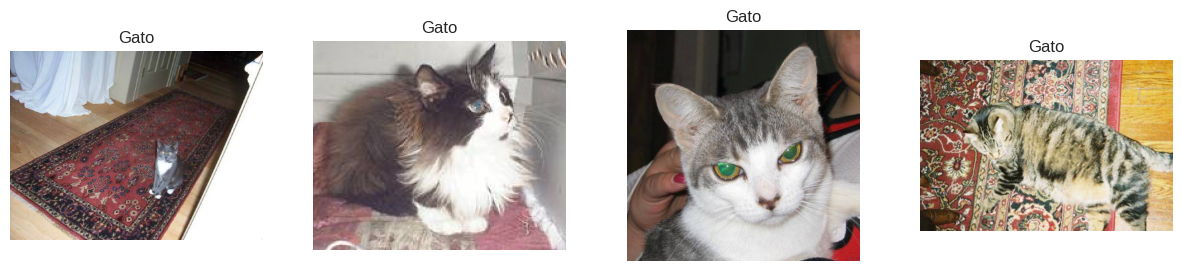

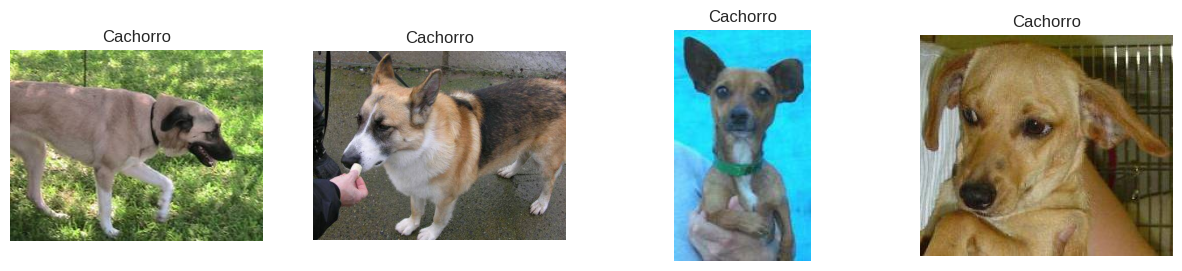

In [ ]:
def show_images_with_labels(results, class_dir, num_images=6):
    plt.figure(figsize=(15, 3))
    for i, (img_name, result) in enumerate(results[:num_images]):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)


        result_lower = result.lower()
        if 'gato' in result_lower:
            title = 'Gato'
        elif 'cachorro' in result_lower:
            title = 'Cachorro'
        else:
            title = 'Desconhecido'

        plt.title(title)
        plt.axis('off')
    plt.show()


show_images_with_labels(cat_results, class_cat_dir, num_images=4)
show_images_with_labels(dog_results, class_dog_dir, num_images=4)


Como podemos ver, as imagens apresentadas foram classificadas pelo modelo com sucesso, mostrando uma boa capacidade de distinguir entre gatos e cachorros.

Confirmamos isso tanto com a função que descreve as imagens com seu nível de confiança, como essa função acima que demonstra de maneira intuitiva.

Agora, vamos salvar o modelo, concluindo esta etapa do projeto!

In [ ]:
save_model(final_lr, 'melhor_modelo_gatos_cachorros')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                                                               fill_value=None,
                                                     

## **Obrigada!**

Obrigada por acompanhar! Todo o processo de construir esse modelo e aprender as técnicas envolvidas foi super enriquecedor pra mim. Aprendi muita coisa nova que com certeza vai ajudar na minha carreira profissional.

[![Gmail](https://img.shields.io/badge/Gmail-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:joanatrindade58@gmail.com)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/joanatrindade-)

    
Made with ❤️ by Joana Trindade.

## **Referências**



[1] [TensorFlow / Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)  

[2] [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[3] [PyCaret](https://pycaret.org/classification/)

[4] [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)  

[5] [tqdm](https://tqdm.github.io/)  

[6] [pandas](https://pandas.pydata.org/docs/)  

[7] [numpy](https://numpy.org/doc/)  

[8] [warnings (Python standard library)](https://docs.python.org/3/library/warnings.html)  

[9] [base64 (Python standard library)](https://docs.python.org/3/library/base64.html)  

[10] [random (Python standard library)](https://docs.python.org/3/library/random.html)  

[11] [os (Python standard library)](https://docs.python.org/3/library/os.html)  

In [ ]:
import nbformat

notebook_path = 'Case_Cromai.ipynb'

with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

for cell in nb.cells:
    if 'metadata' in cell and 'widgets' in cell['metadata']:
        del cell['metadata']['widgets']

clean_path = 'Case_Cromai_limpo.ipynb'
with open(clean_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)

print(f'Notebook limpo salvo em {clean_path}')


FileNotFoundError: [Errno 2] No such file or directory: 'Case_Cromai.ipynb'